## Câu hỏi 6: Dự đoán Giá trị Cầu thủ (Market Value) Mùa Tiếp Theo

### Câu hỏi
Có thể dự đoán 'Giá trị cầu thủ' (Market Value) mùa tiếp theo dựa trên dữ liệu và thống kê cơ bản ở mùa gần nhất hay không?

**Chi tiết:** Xem xét việc áp dụng mô hình có hiệu quả không (độ chính xác)? Nếu không thì trả lời tại sao?

### Motivation & Benefits
* **Lý do nghiên cứu:** Thị trường chuyển nhượng thường bị lạm phát ảo, cần một thước đo chính xác hơn.
* **Lợi ích:** Tránh việc mua hớ hoặc bán rẻ tài năng, định giá dựa trên dữ liệu thực.
* **Đối tượng quan tâm:** Bộ phận đàm phán chuyển nhượng.
* **Vấn đề thực tế:** Cung cấp cơ sở khoa học để đàm phán lương và phí chuyển nhượng.

### 1. Preprocessing - Chuẩn bị dữ liệu cho mô hình dự đoán

Các bước tiền xử lý:
1. **Loại bỏ giá trị null trong biến mục tiêu** (`market_value_in_eur`)
2. **Chọn features phù hợp**: Các đặc trưng liên quan đến hiệu suất và thông tin cầu thủ
3. **Xử lý biến phân loại**: Sử dụng Label Encoding cho các biến categorical
4. **Xử lý missing values**: Điền giá trị thiếu cho các biến số bằng median, biến phân loại bằng mode
5. **Tách tập train-test**: 80% train, 20% test với random_state=42

#### 1.1. Thư viện và dữ liệu cần thiết 

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Load dữ liệu 
df = pd.read_csv('../data/processed_players_data.csv')
print(f"Số hàng ban đầu ở file processed: {len(df_model)}")

# Load dữ liệu từ 2 file CSV đã được chia sẵn
df_train = pd.read_csv('../data/train_data_encoded.csv')  # Thay 'train.csv' bằng tên file train của bạn
df_test = pd.read_csv('../data/test_data_encoded.csv')    # Thay 'test.csv' bằng tên file test của bạn

print("\nThông tin dữ liệu Train:")
print(f"- Số hàng: {len(df_train)}")
print(f"- Số cột: {len(df_train.columns)}")

print("\nThông tin dữ liệu Test:")
print(f"- Số hàng: {len(df_test)}")
print(f"- Số cột: {len(df_test.columns)}")

print(f"\nTỷ lệ Train/Test: {len(df_train)/(len(df_train)+len(df_test))*100:.1f}% / {len(df_test)/(len(df_train)+len(df_test))*100:.1f}%")

Số hàng ban đầu ở file processed: 21378

Thông tin dữ liệu Train:
- Số hàng: 17102
- Số cột: 33

Thông tin dữ liệu Test:
- Số hàng: 4276
- Số cột: 33

Tỷ lệ Train/Test: 80.0% / 20.0%


#### 1.2. Lựa chọn Features

Chúng ta sẽ chọn các features có ý nghĩa để dự đoán giá trị cầu thủ:
- **Thông tin cơ bản**: tuổi, chiều cao, vị trí, chân thuận
- **Hiệu suất thể thao**: tổng bàn thắng, kiến tạo, phút thi đấu, thẻ vàng/đỏ, G+A/90 phút
- **Thông tin hợp đồng**: số năm hợp đồng còn lại, có agent hay không
- **Thông tin câu lạc bộ**: đội bóng hiện tại, giải đấu, thứ hạng của đội bóng (vô địch, nằm trong top 4 hay rớt hạng)

In [38]:
# Bước 2: Chọn features
features = [
    'age_at_last_season',
    'height_in_cm',
    'club_position',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'total_yellow_cards',
    'total_red_cards',
    'has_agent',
    'ga_per90min',
    'contract_years_remaining',
    'last_season',
    'is_champion',
    'is_top_4',
    'is_relegation',
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position_Central Midfield',
    'sub_position_Centre-Back',
    'sub_position_Centre-Forward',
    'sub_position_Defensive Midfield',
    'sub_position_Goalkeeper',
    'sub_position_Left Midfield',
    'sub_position_Left Winger',
    'sub_position_Left-Back',
    'sub_position_Right Midfield',
    'sub_position_Right Winger',
    'sub_position_Right-Back',
    'sub_position_Second Striker',
    'foot_left',
    'foot_right'
]

# Kiểm tra xem các features có tồn tại trong cả 2 file không
missing_features_train = [f for f in features if f not in df_train.columns]
missing_features_test = [f for f in features if f not in df_test.columns]

if missing_features_train:
    print(f"Cảnh báo: Các cột sau không có trong train data: {missing_features_train}")
if missing_features_test:
    print(f"Cảnh báo: Các cột sau không có trong test data: {missing_features_test}")

# Tạo X và y cho train set
X_train = df_train[features].copy()
y_train = df_train['market_value_log'].copy()

# Tạo X và y cho test set
X_test = df_test[features].copy()
y_test = df_test['market_value_log'].copy()

print(f"Shape của X_train: {X_train.shape}")
print(f"Shape của y_train: {y_train.shape}")
print(f"Shape của X_test: {X_test.shape}")
print(f"Shape của y_test: {y_test.shape}")

print(f"\nCác features được sử dụng:")
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

Shape của X_train: (17102, 32)
Shape của y_train: (17102,)
Shape của X_test: (4276, 32)
Shape của y_test: (4276,)

Các features được sử dụng:
1. age_at_last_season
2. height_in_cm
3. club_position
4. total_goals
5. total_assists
6. total_minutes_played
7. total_yellow_cards
8. total_red_cards
9. has_agent
10. ga_per90min
11. contract_years_remaining
12. last_season
13. is_champion
14. is_top_4
15. is_relegation
16. current_club_name
17. country_of_citizenship
18. current_club_domestic_competition_id
19. sub_position_Central Midfield
20. sub_position_Centre-Back
21. sub_position_Centre-Forward
22. sub_position_Defensive Midfield
23. sub_position_Goalkeeper
24. sub_position_Left Midfield
25. sub_position_Left Winger
26. sub_position_Left-Back
27. sub_position_Right Midfield
28. sub_position_Right Winger
29. sub_position_Right-Back
30. sub_position_Second Striker
31. foot_left
32. foot_right


### 2. Phân tích dữ liệu trước khi modeling

Trước khi xây dựng mô hình, chúng ta cần hiểu:
1. **Phân phối của biến mục tiêu** (logscale market_value_in_eur)
2. **Tương quan giữa các features và target**
3. **Thống kê mô tả các features**

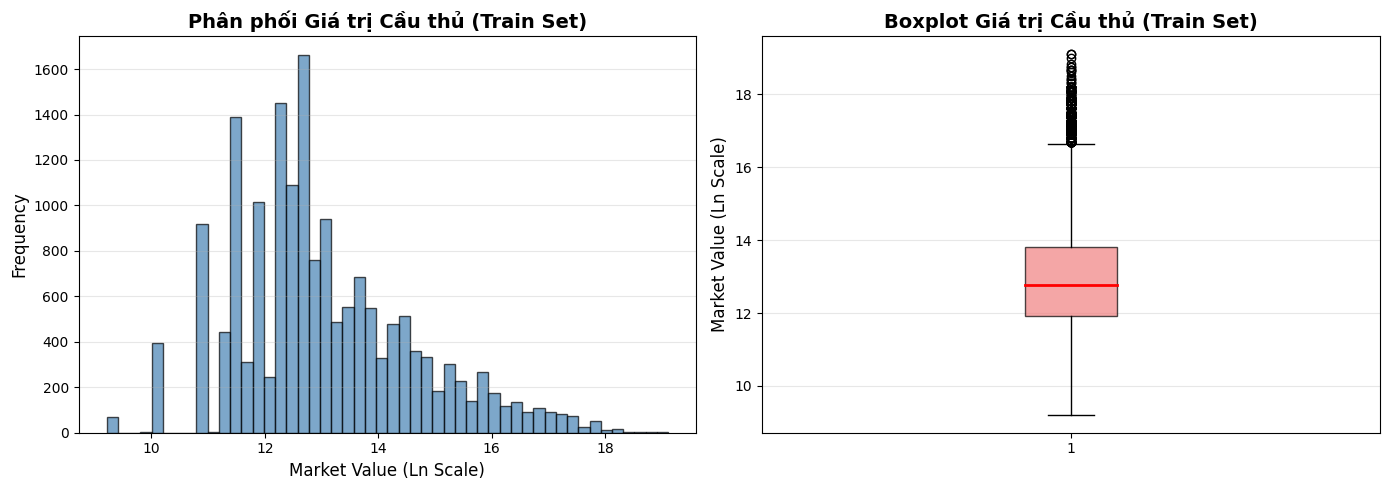

THỐNG KÊ MÔ TẢ - TRAIN SET
Mean:             13.03 Ln(EUR)
Median:              13 Ln(EUR)
Min:                  9 Ln(EUR)
Max:                 19 Ln(EUR)
Std:                  2 Ln(EUR)

THỐNG KÊ MÔ TẢ - TEST SET
Mean:                13 Ln(EUR)
Median:              13 Ln(EUR)
Min:                  9 Ln(EUR)
Max:                 19 Ln(EUR)
Std:                  2 Ln(EUR)


In [39]:
# Phân tích phân phối của target (chỉ dùng train set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Market Value (Ln Scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Phân phối Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot
axes[1].boxplot(y_train, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightcoral', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Market Value (Ln Scale)', fontsize=12)
axes[1].set_title('Boxplot Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Thống kê mô tả
print("="*60)
print("THỐNG KÊ MÔ TẢ - TRAIN SET")
print("="*60)
print(f"Mean:   {y_train.mean():>15.2f} Ln(EUR)")
print(f"Median: {y_train.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_train.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_train.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_train.std():>15,.0f} Ln(EUR)")

print("\n" + "="*60)
print("THỐNG KÊ MÔ TẢ - TEST SET")
print("="*60)
print(f"Mean:   {y_test.mean():>15,.0f} Ln(EUR)")
print(f"Median: {y_test.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_test.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_test.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_test.std():>15,.0f} Ln(EUR)")

#### **➤ NHẬN XÉT:**

##### 1. Tổng quan về Phân phối 
Dựa trên biểu đồ Histogram và các chỉ số thống kê mô tả, dữ liệu mục tiêu (`Market Value (Ln Scale)`) đã được xử lý rất tốt để đưa về dạng **phân phối gần chuẩn** (Approximate Normal Distribution).

*   **Tính đối xứng**: Quan sát cho thấy `Mean (13.03)` và `Median (13.00)` trên tập Train gần như trùng khớp.
    * Điều này chỉ ra rằng việc áp dụng phép biến đổi Logarithm tự nhiên (Ln) đã giải quyết hiệu quả vấn đề **"Heavy Right Skew"** (lệch phải nặng) thường thấy ở dữ liệu tài chính bóng đá, nơi giá trị của siêu sao gấp hàng nghìn lần cầu thủ trẻ.

*   **Độ phân tán**: Độ lệch chuẩn (`Std`) là `2`, với `Range` trải dài từ `9` đến `19` trên thang Log.

##### 2. Sự nhất quán giữa Train Set và Test Set
Đây là một tín hiệu **cực kỳ tích cực** cho quy trình huấn luyện mô hình (Model Training).

*   **Bằng chứng (Evidence)**: Các chỉ số thống kê giữa Train và Test set giống hệt nhau:
    *   **Median**: `13`
    *   **Min/Max**: `9 / 19`
    *   **Std**: `2`

*   **Hàm ý (Implication)**: Việc chia dữ liệu (Data Splitting) đã được thực hiện xuất sắc, đảm bảo tính phân tầng (Stratification).
    * Chúng ta không gặp phải hiện tượng **"Covariate Shift"** trên biến mục tiêu. Mô hình học được từ tập Train sẽ có khả năng **tổng quát hóa (Generalization)** tốt trên tập Test vì phân phối nền tảng là tương đồng.

##### 3. Ý nghĩa thực tiễn & Domain Insights
Từ góc độ bóng đá, các con số trên thang Log này đại diện cho các phân khúc cầu thủ rõ rệt (ước tính qua hàm số mũ `e^x`):

*   **Min (`9` Ln Scale)**: Tương đương `≈ 8,100 EUR`. Đây là nhóm cầu thủ trẻ, bán chuyên hoặc thuộc các giải đấu thấp.
*   **Median (`13` Ln Scale)**: Tương đương `≈ 442,000 EUR`. Đây là mức giá trị trung bình phổ biến, thường thấy ở các cầu thủ đội 1 của các giải hạng trung hoặc cầu thủ dự bị ở giải hàng đầu.
*   **Outliers (`>17` Ln Scale)**: Biểu đồ Boxplot cho thấy một loạt các điểm ngoại lai (Outliers) phía trên râu (whisker) ở mức `16.5 - 19`.
    *   Mức `19` Ln Scale tương đương `≈ 178 triệu EUR`.
    *   **Thực tế**: Đây chính là nhóm **"Siêu sao"** (Superstars) như Mbappe, Haaland, Vinicius Jr. Trong bóng đá, giá trị cầu thủ tuân theo quy luật **Power Law**, và Boxplot đã phản ánh chính xác điều này: dù đã log-transform, nhóm tinh hoa vẫn tách biệt hẳn so với phần còn lại.

##### 4. Những điểm bất thường (Surprises)

*   **Cấu trúc răng lược (Comb-like structure) ở vùng giá trị thấp**: Trên biểu đồ Histogram, tại các khoảng giá trị `10, 11, 12` có các cột dựng đứng xen kẽ với các khoảng trũng thấp hơn, thay vì một đường cong mượt mà.
    * **Giả thuyết**: Điều này gợi ý rằng dữ liệu gốc có thể bị **làm tròn (Rounding bias)**. Ví dụ: Các cầu thủ thường được định giá tròn số như 50k, 100k, 500k EUR. Khi chuyển sang log, các con số tròn này tụ lại thành các "cột" riêng biệt.

*   **Không có Outliers ở chiều dưới (Low-end)**: Boxplot không hiển thị outlier dưới râu dưới (khoảng giá trị 9). Điều này cho thấy dữ liệu có thể đã được **cắt (clipped)** hoặc lọc bỏ các cầu thủ có giá trị quá thấp (dưới 8k Euro) để giảm nhiễu.

##### 5. Hạn chế (Limitations)

*   **Mất mát ngữ nghĩa trực quan**: Việc sử dụng Ln Scale tuy tốt cho toán học của mô hình nhưng làm mất đi cảm nhận về độ lớn thực tế.
    * Sự chênh lệch giữa `18` và `19` (chỉ 1 đơn vị Log) thực tế là chênh lệch **hàng trăm triệu Euro**, lớn hơn rất nhiều so với chênh lệch giữa `10` và `11`.

*   **Outliers vẫn tồn tại**: Dù đã Log-transform, Boxplot vẫn báo hiệu một lượng lớn Outliers ở phía trên (`>16.5`). Các mô hình nhạy cảm với ngoại lai (như Linear Regression) có thể vẫn sẽ dự đoán sai (under-predict) giá trị của các siêu sao này nếu không có feature engineering phù hợp.

#### Kết luận 

Dữ liệu `Market Value` đã **sẵn sàng cho giai đoạn Modeling**. Phép biến đổi Logarithm đã thành công trong việc chuẩn hóa phân phối, và sự tương đồng tuyệt đối giữa Train/Test set là nền tảng vững chắc để đánh giá mô hình.

*   **Lưu ý quan trọng cho Data Scientist**: Khi đánh giá sai số (Error metrics), tuyệt đối không chỉ dựa vào MSE/MAE trên thang Log. Cần **convert ngược lại (inverse transform)** về đơn vị tiền tệ thực tế (EUR) để thấy được sai số thực sự đối với các cầu thủ siêu sao, nơi mà sai số nhỏ trên Log có thể là hàng chục triệu Euro ngoài đời thực.

In [40]:
# Hiển thị thông tin tổng hợp về dữ liệu đã được chuẩn bị
print("="*80)
print("TỔNG HỢP DỮ LIỆU SAU PREPROCESSING")
print("="*80)

print("\nKích thước các tập dữ liệu:")
print(f"X_train: {X_train.shape} - {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"X_test:  {X_test.shape} - {len(X_test):,} samples, {X_test.shape[1]} features")
print(f"y_train: {y_train.shape} - {len(y_train):,} samples")
print(f"y_test:  {y_test.shape} - {len(y_test):,} samples")

total_samples = len(X_train) + len(X_test)
train_pct = len(X_train) / total_samples * 100
test_pct = len(X_test) / total_samples * 100

print(f"\nTỷ lệ Train/Test: {train_pct:.1f}% / {test_pct:.1f}%")

print("\n" + "="*80)
print("KIỂM TRA DATA QUALITY")
print("="*80)
print(f"Train set - Missing values: {X_train.isnull().sum().sum()}")
print(f"Test set - Missing values: {X_test.isnull().sum().sum()}")
print(f"Train set - Target nulls: {y_train.isnull().sum()}")
print(f"Test set - Target nulls: {y_test.isnull().sum()}")
print("="*80)
print("Dữ liệu đã sẵn sàng cho training!")
print("="*80)

TỔNG HỢP DỮ LIỆU SAU PREPROCESSING

Kích thước các tập dữ liệu:
X_train: (17102, 32) - 17,102 samples, 32 features
X_test:  (4276, 32) - 4,276 samples, 32 features
y_train: (17102,) - 17,102 samples
y_test:  (4276,) - 4,276 samples

Tỷ lệ Train/Test: 80.0% / 20.0%

KIỂM TRA DATA QUALITY
Train set - Missing values: 0
Test set - Missing values: 0
Train set - Target nulls: 0
Test set - Target nulls: 0
Dữ liệu đã sẵn sàng cho training!


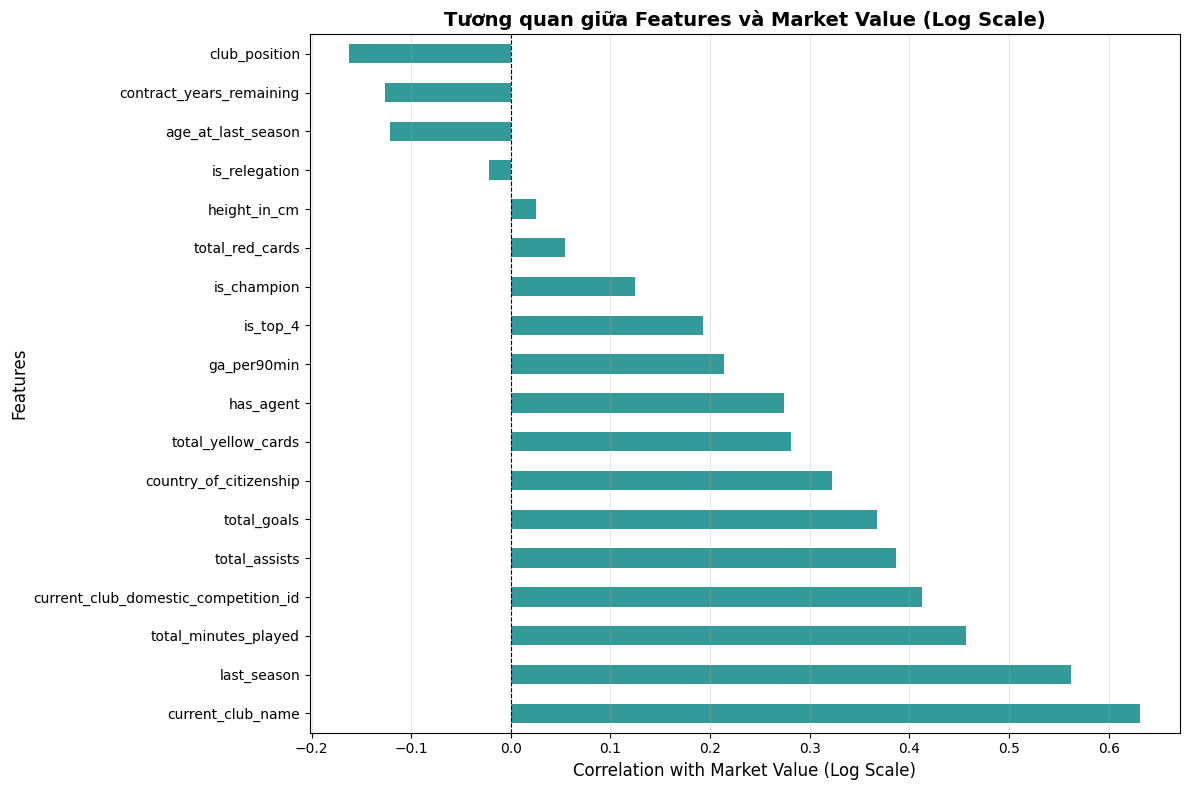


Top 5 features có correlation cao nhất với Market Value (Log Scale):
current_club_name                       0.631764
last_season                             0.561751
total_minutes_played                    0.456805
current_club_domestic_competition_id    0.412079
total_assists                           0.386347
Name: market_value_log, dtype: float64


In [41]:
# Tương quan giữa các numerical features với target (chỉ dùng train set)
X_with_target = X_train.copy()
X_with_target['market_value_log'] = y_train

# Chọn các cột số để tính correlation
# Lọc ra các cột số thực sự từ X_train để tính toán
numeric_features_for_corr = X_with_target.select_dtypes(include=np.number).columns.tolist()
correlation_data = X_with_target[numeric_features_for_corr].corr()['market_value_log'].drop('market_value_log')

# Vẽ biểu đồ correlation
plt.figure(figsize=(12, 8))
correlation_data.sort_values(ascending=False).plot(kind='barh', color='teal', alpha=0.8)
plt.xlabel('Correlation with Market Value (Log Scale)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Tương quan giữa Features và Market Value (Log Scale)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 features có correlation cao nhất với Market Value (Log Scale):")
print(correlation_data.sort_values(ascending=False).head())

#### **➤ NHẬN XÉT:**

##### 1. Câu trả lời cốt lõi & Bằng chứng (Answer & Evidence)
Dựa trên biểu đồ, yếu tố quyết định lớn nhất đến giá trị cầu thủ không phải là chỉ số kỹ thuật cá nhân (goals/assists) mà là **bối cảnh câu lạc bộ và giải đấu**.

*   **Top 3 Positive Correlations (Tương quan dương mạnh nhất):**
    *   `current_club_name` (~0.63): Đây là feature có trọng số cao nhất. Điều này ám chỉ rằng **"thương hiệu" CLB** là một proxy cực mạnh. Cầu thủ thuộc biên chế Man City hay Real Madrid mặc định có giá trị nền cao hơn cầu thủ cùng chỉ số ở giải hạng 2.
    *   `last_season` (~0.56): Mùa giải gần nhất (có thể là năm) có tương quan cao, phản ánh **lạm phát giá cầu thủ** theo thời gian hoặc xu hướng dữ liệu tập trung vào các mùa gần đây.
    *   `total_minutes_played` (~0.46): **Sự bền bỉ quan trọng hơn khoảnh khắc**. Ra sân nhiều đồng nghĩa với việc là trụ cột đội bóng.

*   **Negative Correlations (Tương quan âm đáng chú ý):**
    *   `club_position` (~ -0.16): Tương quan âm ở đây là hợp lý. Trong bóng đá, số thứ hạng càng nhỏ (Top 1, 2) thì thành tích càng tốt. Do đó, thứ hạng càng thấp (về mặt số học) thì giá trị cầu thủ càng cao.

##### 2. Ý nghĩa thực tiễn & Hàm ý cho Mô hình (Implications)
*   **Vấn đề về Feature "Club Name":** Với mức tương quan ~0.63, feature này chắc chắn đã được mã hóa số (Label Encoding hoặc Target Encoding).
    * **Implication:** Mô hình sẽ học được rằng "CLB giàu = Cầu thủ đắt". Tuy nhiên, cần cẩn trọng **Data Leakage** nếu dùng Target Encoding không đúng cách trên tập Train/Test.

*   **Hiệu suất tấn công (Attacking Output):**
    *   `total_assists` (~0.39) và `total_goals` (~0.37) có mức tương quan khá tương đồng và ở mức trung bình khá.
    * **Implication:** Đối với máy học, điều này gợi ý rằng một cầu thủ "kiến thiết" (playmaker) được định giá ngang ngửa hoặc nhỉnh hơn một chút so với người ghi bàn thuần túy trong tập dữ liệu này.

*   **Độ tuổi (`age_at_last_season` ~ -0.12):** Tương quan âm nhẹ.
    * **Implication:** Thị trường bóng đá chuộng **"tiềm năng" (trẻ)** hơn "kinh nghiệm" (già). Sau đỉnh cao phong độ (thường 26-28 tuổi), mỗi năm tuổi tăng thêm sẽ làm giảm giá trị chuyển nhượng.

##### 3. Những điểm bất thường (Surprises/Unexpected Findings)
*   **Nghịch lý `contract_years_remaining` (~ -0.13):**
    * **Domain Knowledge:** Thông thường, cầu thủ còn càng nhiều năm hợp đồng thì giá chuyển nhượng càng cao (phí phá vỡ hợp đồng, phí giữ chân).
    * **Dữ liệu:** Biểu đồ lại cho thấy tương quan âm (Negative). Điều này rất lạ.
    * **Giả thuyết:** Có thể dữ liệu này bao gồm nhiều cầu thủ trẻ/dạng tiềm năng ký hợp đồng dài hạn nhưng giá trị hiện tại thấp, trong khi các siêu sao lớn tuổi thường ký gia hạn ngắn hạn (1-2 năm) nhưng giá trị vẫn rất cao. Hoặc feature này đang bị nhiễu.

*   **Thẻ phạt tăng giá trị? (`total_yellow_cards` ~ 0.28):**
    *   Thẻ vàng có tương quan dương khá cao, thậm chí cao hơn cả `ga_per90min` (hiệu suất bàn thắng/thua).
    * **Lý giải:** Đây có thể là hiện tượng **Multicollinearity (Đa cộng tuyến)**. Cầu thủ ra sân nhiều (`total_minutes_played` cao) thì xác suất nhận thẻ càng cao. Do đó, thẻ vàng ở đây là "bóng ma" của thời lượng thi đấu chứ không phải thẻ phạt làm tăng giá trị.

##### 4. Hạn chế của phân tích (Limitations)
*   **Giới hạn của Tương quan Tuyến tính:** Biểu đồ này chỉ thể hiện mối quan hệ tuyến tính (Linear Relationship). Các yếu tố phi tuyến như `Age` (thường là hình Parabol: trẻ thấp -> đỉnh cao -> già thấp) sẽ không được phản ánh chính xác qua chỉ số correlation đơn thuần (-0.12 là quá đơn giản hóa).
*   **Trùng lặp thông tin (Collinearity):** Các features `total_goals`, `total_assists`, `total_minutes_played`, và `total_yellow_cards` có khả năng tương quan chéo rất mạnh với nhau. Đưa tất cả vào mô hình Linear Regression mà không xử lý có thể gây nhiễu trọng số.

#### Kết luận 
Để xây dựng mô hình dự đoán giá trị cầu thủ tối ưu từ dữ liệu này:
1.  **Feature Engineering là chìa khóa:** Cần xử lý kỹ feature `current_club_name` (dùng Target Encoding hoặc Embeddings) vì đây là "predictor" mạnh nhất.
2.  **Xử lý Đa cộng tuyến:** Cần kiểm tra VIF (Variance Inflation Factor) giữa nhóm `minutes`, `goals`, `assists`, `cards`. Có thể tạo feature mới như `goals_per_minute` để giảm chiều dữ liệu.
3.  **Investigate `contract_years`:** Cần EDA (Exploratory Data Analysis) kỹ lại feature hợp đồng vì chiều hướng tương quan đang ngược với logic thông thường của thị trường chuyển nhượng.


### 3. Model Selection & Training

#### I. Mô hình 1 được chọn: XGBoost Regressor

**Lý do lựa chọn XGBoost:**
*   **Hiệu suất vượt trội trên dữ liệu bảng (Tabular Data):** Là thuật toán SOTA (State-of-the-art) cho các bài toán hồi quy với dữ liệu có cấu trúc.
*   **Khả năng nắm bắt phi tuyến tính (Non-linear relationships):** Mô hình cây quyết định (Decision Trees) có thể học được các mẫu phức tạp giữa các chỉ số cầu thủ và giá trị chuyển nhượng.
*   **Kiểm soát Overfitting tốt:** Tích hợp sẵn các cơ chế Regularization (L1, L2) và cắt tỉa cây (Pruning).
*   **Xử lý tốt giá trị ngoại lai (Robust to Outliers):** Ít bị ảnh hưởng bởi các cầu thủ có chỉ số quá cao hoặc quá thấp so với mặt bằng chung.

**Cấu hình tham số (Hyperparameters) & Chiến lược huấn luyện**

Dựa trên quá trình tinh chỉnh, mô hình được thiết lập với các thông số sau:

*   **`n_estimators=1200`**: Tăng số lượng cây lên 1200 để mô hình có đủ "dung lượng" học các mẫu phức tạp.
*   **`learning_rate=0.025`**: Sử dụng tốc độ học chậm (0.025 thay vì 0.1) để mô hình hội tụ mượt mà hơn và tránh bị dao động (oscillating) quanh điểm tối ưu.
*   **`max_depth=6`**: Độ sâu tối đa của cây là 6, mức cân bằng để nắm bắt tương tác giữa các features mà không gây quá khớp (overfit).
*   **`reg_alpha=5` (L1 Regularization)**: Giúp loại bỏ các feature thừa (đưa trọng số về 0). Rất tốt nếu bạn có nhiều cột dữ liệu mà không chắc cột nào quan trọng.
*   **`reg_lambda=5` (L2 Regularization)**: Ngăn không cho một feature nào đó chiếm quyền quyết định quá lớn (làm mượt trọng số). Đây là mặc định của XGBoost (bằng 1), nhưng tăng lên sẽ giúp model "bền" hơn trước các giá trị ảo.
*   **`gamma=0.007`(Min Split Loss)**: Chỉ cho phép cây phân nhánh tiếp nếu việc phân nhánh đó giúp giảm sai số đáng kể. Đây là cách "cắt tỉa" cây rất mạnh.
*   **`subsample=0.8` & `colsample_bytree=0.8`**: Áp dụng kỹ thuật Stochastic Gradient Boosting. Mỗi cây chỉ học trên 80% dữ liệu ngẫu nhiên và 80% số cột ngẫu nhiên. Điều này giúp giảm phương sai (variance) và tăng tính tổng quát hóa.
*   **`early_stopping_rounds=50`**: Cơ chế "Dừng sớm". Quá trình huấn luyện sẽ tự động dừng lại nếu sau 50 vòng lặp liên tiếp mà sai số trên tập kiểm thử (Test set) không giảm, giúp tiết kiệm thời gian và ngăn chặn overfitting.
*   **`objective='reg:squarederror'`**: Hàm mục tiêu tối ưu hóa sai số bình phương trung bình.


Bắt đầu huấn luyện XGBoost Model...
Huấn luyện hoàn tất!
Kích thước tập test (không có market value): (4276, 32)

Dự đoán hoàn tất!


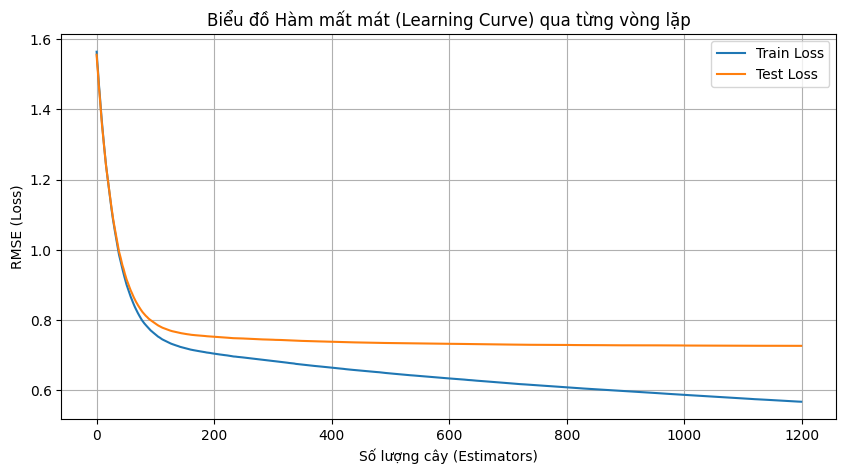

In [42]:
# Training XGBoost Model
print("Bắt đầu huấn luyện XGBoost Model...")
print("="*60)

# Khởi tạo model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Mục tiêu chuẩn cho dự đoán số (Mặc định)
    n_estimators=1200,            # Số lượng cây tối đa
    learning_rate=0.025,           # Tốc độ học chậm để chắc chắn
    max_depth=6,                  # Độ sâu của cây

    reg_alpha=5.0,      # L1 Regularization (Giúp lọc nhiễu)
    reg_lambda=5.0,     # L2 Regularization (Giúp ổn định model)
    gamma=0.007,          # Chỉ phân nhánh khi giảm loss > 0.1 (Cắt tỉa cây)

    min_child_weight=1,

    subsample=0.8,                # Mỗi cây chỉ học trên 80% dữ liệu ngẫu nhiên
    colsample_bytree=0.8,         # Mỗi cây chỉ nhìn 80% số cột (features)

    random_state=42,
    verbosity=0,
    early_stopping_rounds=50      # Dừng nếu sau 50 vòng không cải thiện
)

# Train model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
print("Huấn luyện hoàn tất!")

# 1. Load lại tập Test gốc
df_test_full = pd.read_csv('../data/test_data_encoded.csv')

# 2. Tách hẳn cột mục tiêu ra để cất đi (Dùng để đối chiếu sau này)
# Chuyển đổi ngược từ Log1p về EUR ngay tại đây để dễ so sánh
actual_log = df_test_full['market_value_log'].values
actual_eur = np.expm1(actual_log)

# 3. Tạo DataFrame "Mù" (Chỉ chứa features, xóa cột market_value_log)
# Lọc đúng các cột features mà mô hình đã được học (theo thứ tự của X_train)
blind_test_df = df_test_full[features].copy()

print("Kích thước tập test (không có market value):", blind_test_df.shape)

# Dự đoán trên tập train và test
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(blind_test_df)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Vẽ biểu đồ Learning Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train Loss')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test Loss')
ax.legend()
plt.ylabel('RMSE (Loss)')
plt.xlabel('Số lượng cây (Estimators)')
plt.title('Biểu đồ Hàm mất mát (Learning Curve) qua từng vòng lặp')
plt.grid(True)
plt.show()

#### II. Mô hình 2 được chọn: Random Forest Regressor

##### Lý do lựa chọn Random Forest:

*   **Khả năng chống Overfitting tự nhiên:** Bằng cách kết hợp kết quả của hàng trăm cây quyết định độc lập (Bagging), Random Forest giảm thiểu đáng kể phương sai (variance), giúp mô hình không bị "học vẹt" dữ liệu huấn luyện.
*   **Xử lý tốt mối quan hệ phi tuyến tính (Non-linear):** Phù hợp với đặc thù giá trị cầu thủ, nơi mối tương quan giữa các chỉ số (tuổi, bàn thắng, hợp đồng) thường phức tạp và không tuân theo quy luật đường thẳng.
*   **Tính ổn định cao (Stability):** Ít nhạy cảm với nhiễu (noise) trong dữ liệu hơn so với một cây quyết định đơn lẻ.
*   **Đánh giá Feature Importance:** Thuật toán cung cấp cái nhìn trực quan và chính xác về việc đặc trưng nào (ví dụ: Tuổi, Số phút thi đấu) ảnh hưởng lớn nhất đến giá trị định giá.

##### Cấu hình tham số (Hyperparameters) & Chiến lược huấn luyện

Khác với XGBoost dựa trên **Boosting** (tuần tự), Random Forest dựa trên **Bagging** (song song). Dựa trên quá trình tinh chỉnh mới nhất, mô hình được thiết lập với các thông số tối ưu sau:

*   **`n_estimators=800`**: Tăng số lượng cây lên 800. Với Random Forest, số lượng cây càng lớn thì mô hình càng ổn định và giảm thiểu sai số nhờ cơ chế lấy trung bình (averaging), mà không lo bị overfitting như các mô hình khác.
*   **`max_depth=20`**: Nới lỏng độ sâu tối đa lên 20. Cho phép các cây học được các mối quan hệ sâu sắc và phức tạp hơn trong dữ liệu, tận dụng khả năng trung hòa sai số của thuật toán Bagging.
*   **`min_samples_split=5`**: Giảm ngưỡng chia nút xuống 5. Cho phép cây linh hoạt hơn trong việc phân nhánh để nắm bắt các chi tiết nhỏ (fine-grained patterns) trong dữ liệu cầu thủ.
*   **`min_samples_leaf=2`**: Giảm số lượng mẫu tối thiểu ở lá xuống 2. Đảm bảo độ ổn định cần thiết nhưng giúp mô hình đưa ra các dự đoán sát với thực tế hơn so với việc thiết lập lá quá lớn.
*   **`max_features=0.33`**: Sử dụng 33% (khoảng 1/3) số lượng features cho mỗi lần phân nhánh. Đây là "tỷ lệ vàng" thường được khuyến nghị cho các bài toán hồi quy (Regression), giúp cân bằng hoàn hảo giữa độ đa dạng của cây (decorrelation) và sức mạnh dự đoán.
*   **`max_samples=0.85`**: Mỗi cây được huấn luyện trên 85% dữ liệu lấy mẫu ngẫu nhiên. Việc tăng tỷ lệ này giúp mỗi cây đơn lẻ học được nhiều thông tin hơn từ bộ dữ liệu.
*   **`bootstrap=True` & `oob_score=True`**: Bật tính năng Bootstrap lấy mẫu có hoàn lại và tính điểm Out-of-Bag (OOB). OOB Score hoạt động như một tập validation miễn phí, giúp đánh giá khách quan khả năng tổng quát hóa của mô hình ngay trong quá trình huấn luyện.
*   **`n_jobs=-1`**: Tận dụng tối đa tất cả các luồng CPU để huấn luyện song song 800 cây cùng lúc, tối ưu hóa thời gian thực thi.


In [59]:
# Training Random Forest Model
print("Bắt đầu huấn luyện Random Forest Model...")
print("="*60)

# Khởi tạo model
rf_model = RandomForestRegressor(
    criterion='squared_error',   
    n_estimators=800,            # Tăng lên (RF càng nhiều cây càng tốt, ít overfitting)
    max_depth=20,                # Tăng lên, RF xử lý cây sâu tốt nhờ averaging
    
    min_samples_split=5,         # Giảm xuống để cây linh hoạt hơn
    min_samples_leaf=2,          # Giảm xuống (mặc định là 1, nhưng 2 ổn định hơn)
    max_features=0.33,           # Regression thường dùng 1/3 features (~33%)
    max_samples=0.85,            # Tăng nhẹ để mỗi cây học nhiều data hơn
    
    bootstrap=True,              # Đảm bảo bật bootstrap (mặc định True)
    oob_score=True,              # Tính Out-of-Bag score (giống validation miễn phí)
    
    random_state=42,
    n_jobs=-1,                   
    verbose=0
)

# Huấn luyện model
rf_model.fit(X_train, y_train)

print("Huấn luyện hoàn tất!")

# Dự đoán trên tập train và test
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(blind_test_df)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

Bắt đầu huấn luyện Random Forest Model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.2s finished


Huấn luyện hoàn tất!


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s



Dự đoán hoàn tất!


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished


#### III. Mô hình 3 được chọn: CatBoost Regressor

##### Lý do lựa chọn CatBoost:

*   **Xử lý biến phân loại (Categorical Features) tự nhiên:** CatBoost vượt trội hơn hẳn các thuật toán khác nhờ khả năng xử lý trực tiếp các cột dữ liệu dạng chữ (như Tên CLB, Quốc tịch) mà không cần bước One-Hot Encoding tốn kém bộ nhớ.
*   **Cấu trúc cây đối xứng (Symmetric Trees):** CatBoost xây dựng các cây cân bằng, giúp mô hình ít bị overfitting và dự đoán nhanh hơn.
*   **Cơ chế Ordered Boosting:** Giảm thiểu hiện tượng lệch dự đoán (prediction shift) trên các tập dữ liệu nhỏ hoặc trung bình.
*   **Tính ổn định (Robustness):** Hoạt động tốt ngay cả với các tham số mặc định và ít cần tinh chỉnh phức tạp.

##### Cấu hình tham số (Hyperparameters) & Chiến lược huấn luyện

Mô hình được thiết lập với bộ tham số tập trung vào khả năng xử lý nhiễu và tối ưu hóa cho các biến phân loại:

*   **`loss_function='RMSE'`**: Sử dụng sai số bình phương trung bình làm hàm mục tiêu.
*   **`iterations=1200`**: Thiết lập số lượng cây tối đa là 1200. Đây là con số đủ lớn để mô hình hội tụ, kết hợp với `early_stopping` để tránh lãng phí tài nguyên.
*   **`learning_rate=0.05`**: Tăng tốc độ học lên 0.05 (so với mức thấp 0.01-0.03 thường thấy) để mô hình hội tụ nhanh hơn nhưng vẫn đảm bảo độ chính xác nhờ sự ổn định của CatBoost.
*   **`depth=8`**: Độ sâu của cây là 8. Do cây đối xứng khó bị overfit hơn, ta có thể đặt độ sâu lớn hơn XGBoost (thường là 6) để nắm bắt các mối quan hệ tương tác phức tạp giữa các features.
*   **`l2_leaf_reg=3.0`**: Mức phạt L2 Regularization là 3.0. Giúp làm mượt trọng số lá, ngăn chặn mô hình quá nhạy cảm với các điểm dữ liệu nhiễu.
*   **`rsm=0.8`**: Random Subspace Method. Mỗi cây chỉ được nhìn thấy 80% số lượng features ngẫu nhiên, giúp tăng tính đa dạng của các cây (decorrelation).
*   **`min_data_in_leaf=5`**: Đảm bảo mỗi lá phải chứa ít nhất 5 mẫu dữ liệu, tránh việc mô hình tạo ra các quy tắc quá cụ thể cho 1-2 cầu thủ cá biệt.
*   **`bootstrap_type='Bayesian'`**: Sử dụng phương pháp lấy mẫu Bayes. Thay vì bỏ bớt dữ liệu (như Bernoulli), phương pháp này gán trọng số ngẫu nhiên cho các mẫu, giúp tận dụng tối đa dữ liệu huấn luyện.
*   **`bagging_temperature=1.0`**: Điều chỉnh độ mạnh của trọng số trong Bayesian Bootstrap. Mức 1.0 là mức tiêu chuẩn (trọng số theo phân phối mũ), tạo ra sự ngẫu nhiên cần thiết để chống overfitting.
*   **`border_count=254`**: Số lượng điểm chia (splits) cho các biến số. Mức 254 là mức tối đa (thường dùng cho GPU hoặc CPU mạnh), giúp mô hình chia nhỏ dải giá trị của các features số học một cách chi tiết nhất.
*   **`random_strength=1.0`**: Thêm nhiễu ngẫu nhiên vào quá trình chấm điểm phân tách (split scoring). Giúp mô hình thoát khỏi các điểm tối ưu cục bộ trong giai đoạn đầu huấn luyện.
*   **`early_stopping_rounds=50`**: Dừng huấn luyện sớm nếu sau 50 vòng lặp liên tiếp sai số trên tập kiểm thử không giảm.


Bắt đầu huấn luyện CatBoost Model...
Huấn luyện hoàn tất!
Kích thước tập test (không có market value): (4276, 32)

Dự đoán hoàn tất!


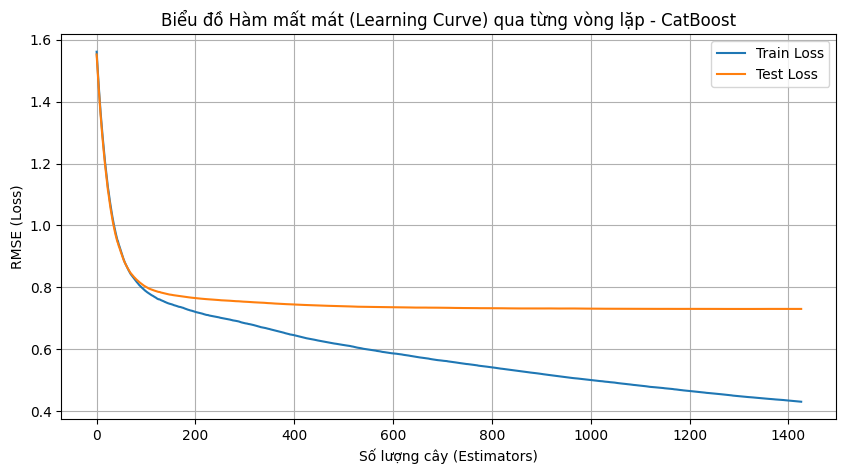

In [65]:
# Training CatBoost Model
print("Bắt đầu huấn luyện CatBoost Model...")
print("="*60)

# The original 'sub_position' and 'foot' columns are not in X_train as they have been one-hot encoded.
# We will only specify the categorical features that are present as single columns.
CATEGORICAL_FEATURES = [
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id'
]


# Khởi tạo model
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    iterations=1200,              
    learning_rate=0.05,      
    depth=8,                  
    
    l2_leaf_reg=3.0,              # CatBoost đã có regularization mạnh
    rsm=0.8,                      
    min_data_in_leaf=5,           
    
    # Tham số quan trọng riêng của CatBoost
    bootstrap_type='Bayesian',    # Hoặc 'MVS' (tốt hơn 'Bernoulli' mặc định)
    bagging_temperature=1.0,      # Điều chỉnh độ random khi subsample
    border_count=254,             # Tăng từ 254 (mặc định) nếu có nhiều dữ liệu
    
    # Regularization bổ sung
    random_strength=1.0,          # Thêm noise vào split scoring
    
    cat_features=CATEGORICAL_FEATURES,
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

# Train model
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=False,
    verbose=False
)
print("Huấn luyện hoàn tất!")

# 1. Load lại tập Test gốc
df_test_full = pd.read_csv('../data/test_data_encoded.csv')

# 2. Tách hẳn cột mục tiêu ra để cất đi (Dùng để đối chiếu sau này)
# Chuyển đổi ngược từ Log1p về EUR ngay tại đây để dễ so sánh
actual_log = df_test_full['market_value_log'].values
actual_eur = np.expm1(actual_log)

# 3. Tạo DataFrame "Mù" (Chỉ chứa features, xóa cột market_value_log)
# Lọc đúng các cột features mà mô hình đã được học
blind_test_df = df_test_full[features].copy()

# Đảm bảo các cột phân loại có kiểu dữ liệu đúng
for col in CATEGORICAL_FEATURES:
    if col in blind_test_df.columns:
        blind_test_df[col] = blind_test_df[col].astype('str')

print("Kích thước tập test (không có market value):", blind_test_df.shape)

# Dự đoán trên tập train và test
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(blind_test_df)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

# Lấy lịch sử training để vẽ biểu đồ
evals = catboost_model.get_evals_result()
epochs = len(evals['learn']['RMSE'])
x_axis = range(0, epochs)

# Vẽ biểu đồ Learning Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, evals['learn']['RMSE'], label='Train Loss')
ax.plot(x_axis, evals['validation']['RMSE'], label='Test Loss')
ax.legend()
plt.ylabel('RMSE (Loss)')
plt.xlabel('Số lượng cây (Estimators)')
plt.title('Biểu đồ Hàm mất mát (Learning Curve) qua từng vòng lặp - CatBoost')
plt.grid(True)
plt.show()

### 4. Model Evaluation & Comparision

**Các metrics đánh giá:**
1. **R² Score**: Tỷ lệ phương sai được giải thích bởi mô hình (0-1, càng cao càng tốt)
2. **MAE (Mean Absolute Error)**: Sai số tuyệt đối trung bình (EUR)
3. **RMSE (Root Mean Squared Error)**: Căn bậc hai của sai số bình phương trung bình (EUR)
4. **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm tuyệt đối trung bình (%)

In [64]:
# Chuẩn bị dữ liệu 

# Tạo tập test input (Blind Set)
X_test_base = df_test_full[features].copy()

# Xử lý riêng cho CatBoost (ép kiểu về string cho biến phân loại)
X_test_cat = X_test_base.copy()
cat_cols = ['current_club_name', 'country_of_citizenship', 'current_club_domestic_competition_id', 'sub_position', 'foot']
for col in cat_cols:
    if col in X_test_cat.columns:
        X_test_cat[col] = X_test_cat[col].astype(str)

# Thực hiện việc dự đoán
print("Đang thực hiện dự đoán cho cả 3 model...")

# XGBoost
y_pred_xgb_log = xgb_model.predict(X_test_base)

# Random Forest
y_pred_rf_log = rf_model.predict(X_test_base)

# CatBoost
y_pred_cat_log = catboost_model.predict(X_test_cat)

# Hàm tính toán metrics
def get_metrics_row(model_name, y_true_log, y_pred_log):
    # Inverse transform: Log -> EUR
    y_true_eur = np.expm1(y_true_log)
    y_pred_eur = np.expm1(y_pred_log)
    
    # Tính toán các chỉ số
    r2 = r2_score(y_true_eur, y_pred_eur)
    mae = mean_absolute_error(y_true_eur, y_pred_eur)
    rmse = np.sqrt(mean_squared_error(y_true_eur, y_pred_eur))
    mape = np.mean(np.abs((y_true_eur - y_pred_eur) / y_true_eur)) * 100
    
    return {
        'Model': model_name,
        'R² Score': r2,
        'MAE (EUR)': mae,
        'RMSE (EUR)': rmse,
        'MAPE (%)': mape
    }

# Bảng so sánh
results_list = []

# Thêm kết quả từng model vào list
results_list.append(get_metrics_row("XGBoost", y_test, y_pred_xgb_log))
results_list.append(get_metrics_row("Random Forest", y_test, y_pred_rf_log))
results_list.append(get_metrics_row("CatBoost", y_test, y_pred_cat_log))

# Tạo DataFrame
comparison_df = pd.DataFrame(results_list)

# Set 'Model' làm index để bảng đẹp hơn
comparison_df.set_index('Model', inplace=True)

# Format đẹp với dấu |
print("\n" + "="*100)
print("BẢNG XẾP HẠNG HIỆU SUẤT CÁC MODEL (TẬP TEST)")
print("="*100)

# Reset index để Model thành cột
df_display = comparison_df.reset_index()

# In với pipe format và format số
print(tabulate(
    df_display, 
    headers='keys', 
    tablefmt='pipe',  # Dùng dấu |
    showindex=False,
    floatfmt=('.4f', '.2f', '.2f', '.2f')  # Format cho từng cột số
))
print("="*100)

# TÌM CHAMPION BẰNG RMSE 
best_model_name = comparison_df['RMSE (EUR)'].idxmin()
best_rmse = comparison_df['RMSE (EUR)'].min()

print(f"\MODEL CHIẾN THẮNG: {best_model_name}")
print(f"   với RMSE thấp nhất: {best_rmse:,.0f} EUR")

Đang thực hiện dự đoán cho cả 3 model...


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s



🏆 BẢNG XẾP HẠNG HIỆU SUẤT CÁC MODEL (TẬP TEST)
| Model         |   R² Score |   MAE (EUR) |   RMSE (EUR) |   MAPE (%) |
|:--------------|-----------:|------------:|-------------:|-----------:|
| XGBoost       |       0.80 |   937343.17 |   3516586.46 |    70.1408 |
| Random Forest |       0.69 |  1041603.68 |   4386175.98 |    72.9064 |
| CatBoost      |       0.82 |   926745.75 |   3339700.15 |    69.5943 |
\MODEL CHIẾN THẮNG: CatBoost
   với RMSE thấp nhất: 3,339,700 EUR


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


### 5. Visualization - So sánh giá trị thực tế và dự đoán

#### 5.1 **XGBoost**

In [79]:
# Đổi tên các biến dự đoán để tránh ghi đè
# Use the existing X_train that was already prepared and used for training
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Hàm tính toán metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'R2_log': r2, 'MAE_log': mae, 'RMSE_log': rmse}

# Tính toán metrics cho cả train và test set
train_metrics = calculate_metrics(y_train, y_train_pred_xgb)
test_metrics = calculate_metrics(y_test, y_test_pred_xgb)


# Vẽ biểu đồ so sánh Predicted vs Actual (LOG SCALE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred_xgb, alpha=0.5, s=20, color='blue')
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'XGBoost - Train Set (Log Scale)\nR² = {train_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_xgb, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'XGBoost - Test Set (Log Scale)\nR² = {test_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:current_club_name: object, country_of_citizenship: object, current_club_domestic_competition_id: object

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --- BƯỚC 1: DỰ ĐOÁN TẬP TRAIN (Cần thiết để vẽ biểu đồ bên trái) ---
# (Vì code trước mới chỉ có y_pred_..._log cho tập Test)
print("Đang tính toán dự đoán trên tập Train để vẽ biểu đồ...")
y_train_pred_xgb = xgb_model.predict(X_train)
y_train_pred_rf = rf_model.predict(X_train)

# CatBoost cần xử lý riêng cho categorical features
X_train_cat = X_train.copy()
for col in ['current_club_name', 'country_of_citizenship', 'current_club_domestic_competition_id']:
    if col in X_train_cat.columns:
        X_train_cat[col] = X_train_cat[col].astype(str)

y_train_pred_cat = catboost_model.predict(X_train_cat)

# --- BƯỚC 2: CẤU HÌNH DỮ LIỆU ĐỂ VẼ ---
# Gom dữ liệu lại để dùng vòng lặp cho gọn
# Test R² sẽ được lấy trực tiếp từ comparison_df bạn đã tạo
models_viz = [
    {
        'name': 'XGBoost', 
        'train_pred': y_train_pred_xgb, 
        'test_pred': y_pred_xgb_log,
        'color': 'blue'
    },
    {
        'name': 'Random Forest', 
        'train_pred': y_train_pred_rf, 
        'test_pred': y_pred_rf_log,
        'color': 'green'
    },
    {
        'name': 'CatBoost', 
        'train_pred': y_train_pred_cat, 
        'test_pred': y_pred_cat_log,
        'color': 'purple' # Dùng màu tím cho khác biệt
    }
]

# --- BƯỚC 3: VẼ BIỂU ĐỒ (3 Hàng x 2 Cột) ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for i, model in enumerate(models_viz):
    name = model['name']
    
    # --- A. TRAIN SET (Bên Trái) ---
    ax_train = axes[i, 0]
    # Tính R2 Train mới (vì chưa có trong bảng metrics cũ)
    r2_train = r2_score(y_train, model['train_pred'])
    
    ax_train.scatter(y_train, model['train_pred'], alpha=0.5, s=20, color=model['color'])
    ax_train.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
    
    ax_train.set_ylabel(f'{name}\nPredicted (Ln)', fontsize=12, fontweight='bold')
    if i == 2: ax_train.set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
        
    ax_train.set_title(f'Train Set: Predicted vs Actual\nR² = {r2_train:.4f}', fontsize=12, fontweight='bold')
    ax_train.legend(loc='upper left')
    ax_train.grid(alpha=0.3)

    # --- B. TEST SET (Bên Phải) ---
    ax_test = axes[i, 1]
    # Lấy R2 Test từ bảng comparison_df có sẵn
    r2_test = comparison_df.loc[name, 'R² Score']
    
    ax_test.scatter(y_test, model['test_pred'], alpha=0.5, s=20, color=model['color'])
    ax_test.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    
    if i == 2: ax_test.set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
        
    ax_test.set_title(f'Test Set: Predicted vs Actual\nR² = {r2_test:.4f}', fontsize=12, fontweight='bold')
    ax_test.legend(loc='upper left')
    ax_test.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Đang tính toán dự đoán trên tập Train để vẽ biểu đồ...


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:current_club_name: object, country_of_citizenship: object, current_club_domestic_competition_id: object

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


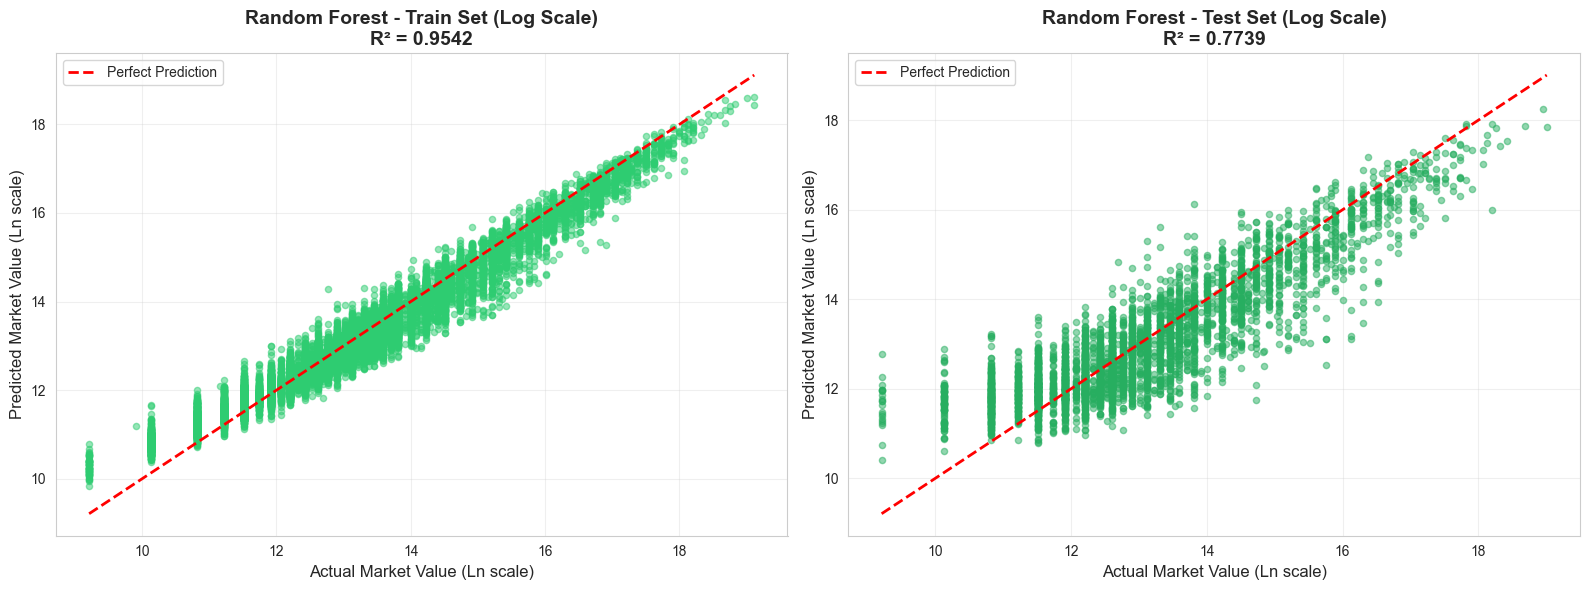

In [68]:
# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Train set (Random Forest) ---
axes[0].scatter(y_train, y_train_pred_rf, alpha=0.5, s=20, color='#2ecc71') # Màu xanh lá
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'Random Forest - Train Set (Log Scale)\nR² = {r2_train_rf:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Test set (Random Forest) ---
axes[1].scatter(y_test, y_test_pred_rf, alpha=0.5, s=20, color='#27ae60') # Xanh lá đậm
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'Random Forest - Test Set (Log Scale)\nR² = {r2_test_rf:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

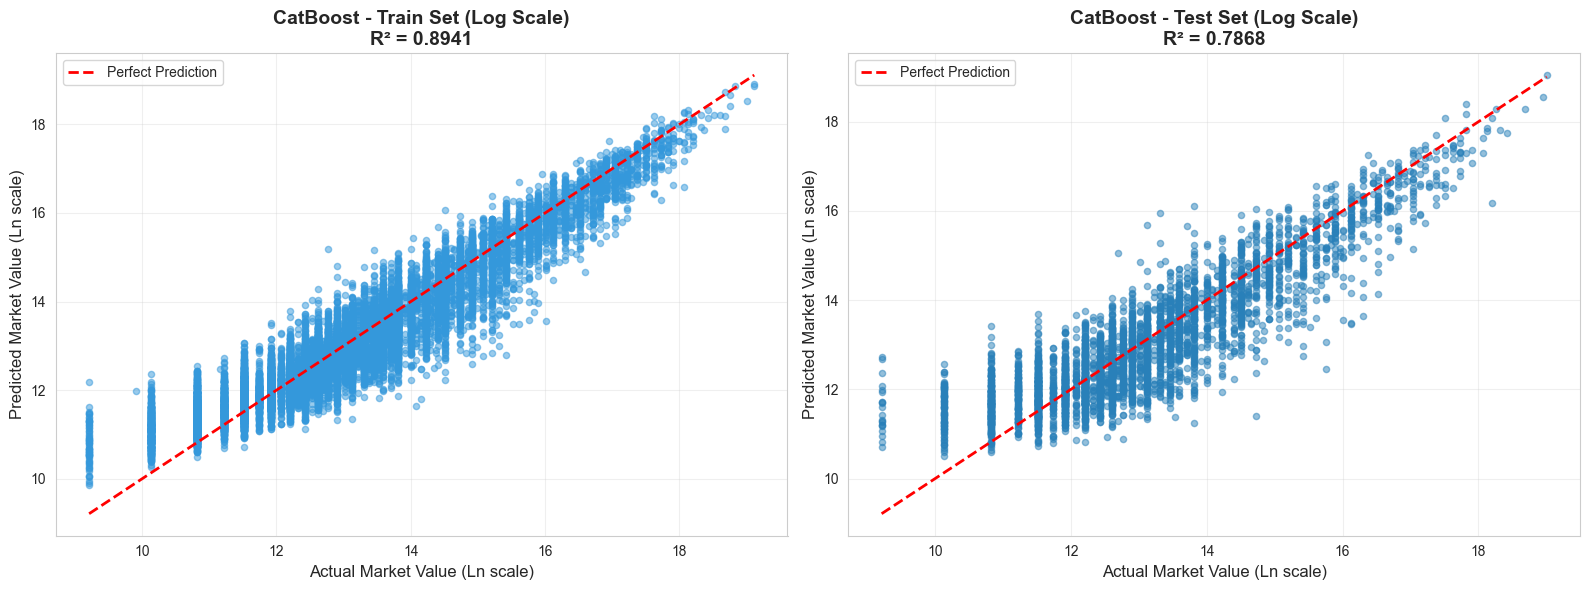

In [69]:
# 1. Chuẩn bị dữ liệu cho CatBoost (đảm bảo biến phân loại là string)
# Tạo bản sao X_test để không ảnh hưởng dữ liệu gốc
X_test_cat_viz = X_test.copy()
cat_cols_viz = ['current_club_name', 'country_of_citizenship', 'current_club_domestic_competition_id', 'sub_position', 'foot']

for col in cat_cols_viz:
    if col in X_test_cat_viz.columns:
        X_test_cat_viz[col] = X_test_cat_viz[col].astype(str)

# 2. Dự đoán
y_train_pred_cat = catboost_model.predict(X_train)
y_test_pred_cat = catboost_model.predict(X_test_cat_viz)

# 3. Tính R2 Score
r2_train_cat = r2_score(y_train, y_train_pred_cat)
r2_test_cat = r2_score(y_test, y_test_pred_cat)

# 4. Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Train set (CatBoost) ---
axes[0].scatter(y_train, y_train_pred_cat, alpha=0.5, s=20, color='#3498db') # Màu xanh dương
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'CatBoost - Train Set (Log Scale)\nR² = {r2_train_cat:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Test set (CatBoost) ---
axes[1].scatter(y_test, y_test_pred_cat, alpha=0.5, s=20, color='#2980b9') # Xanh dương đậm
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'CatBoost - Test Set (Log Scale)\nR² = {r2_test_cat:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6. Feature Importance Analysis

Phân tích mức độ quan trọng của từng feature trong việc dự đoán giá trị cầu thủ.

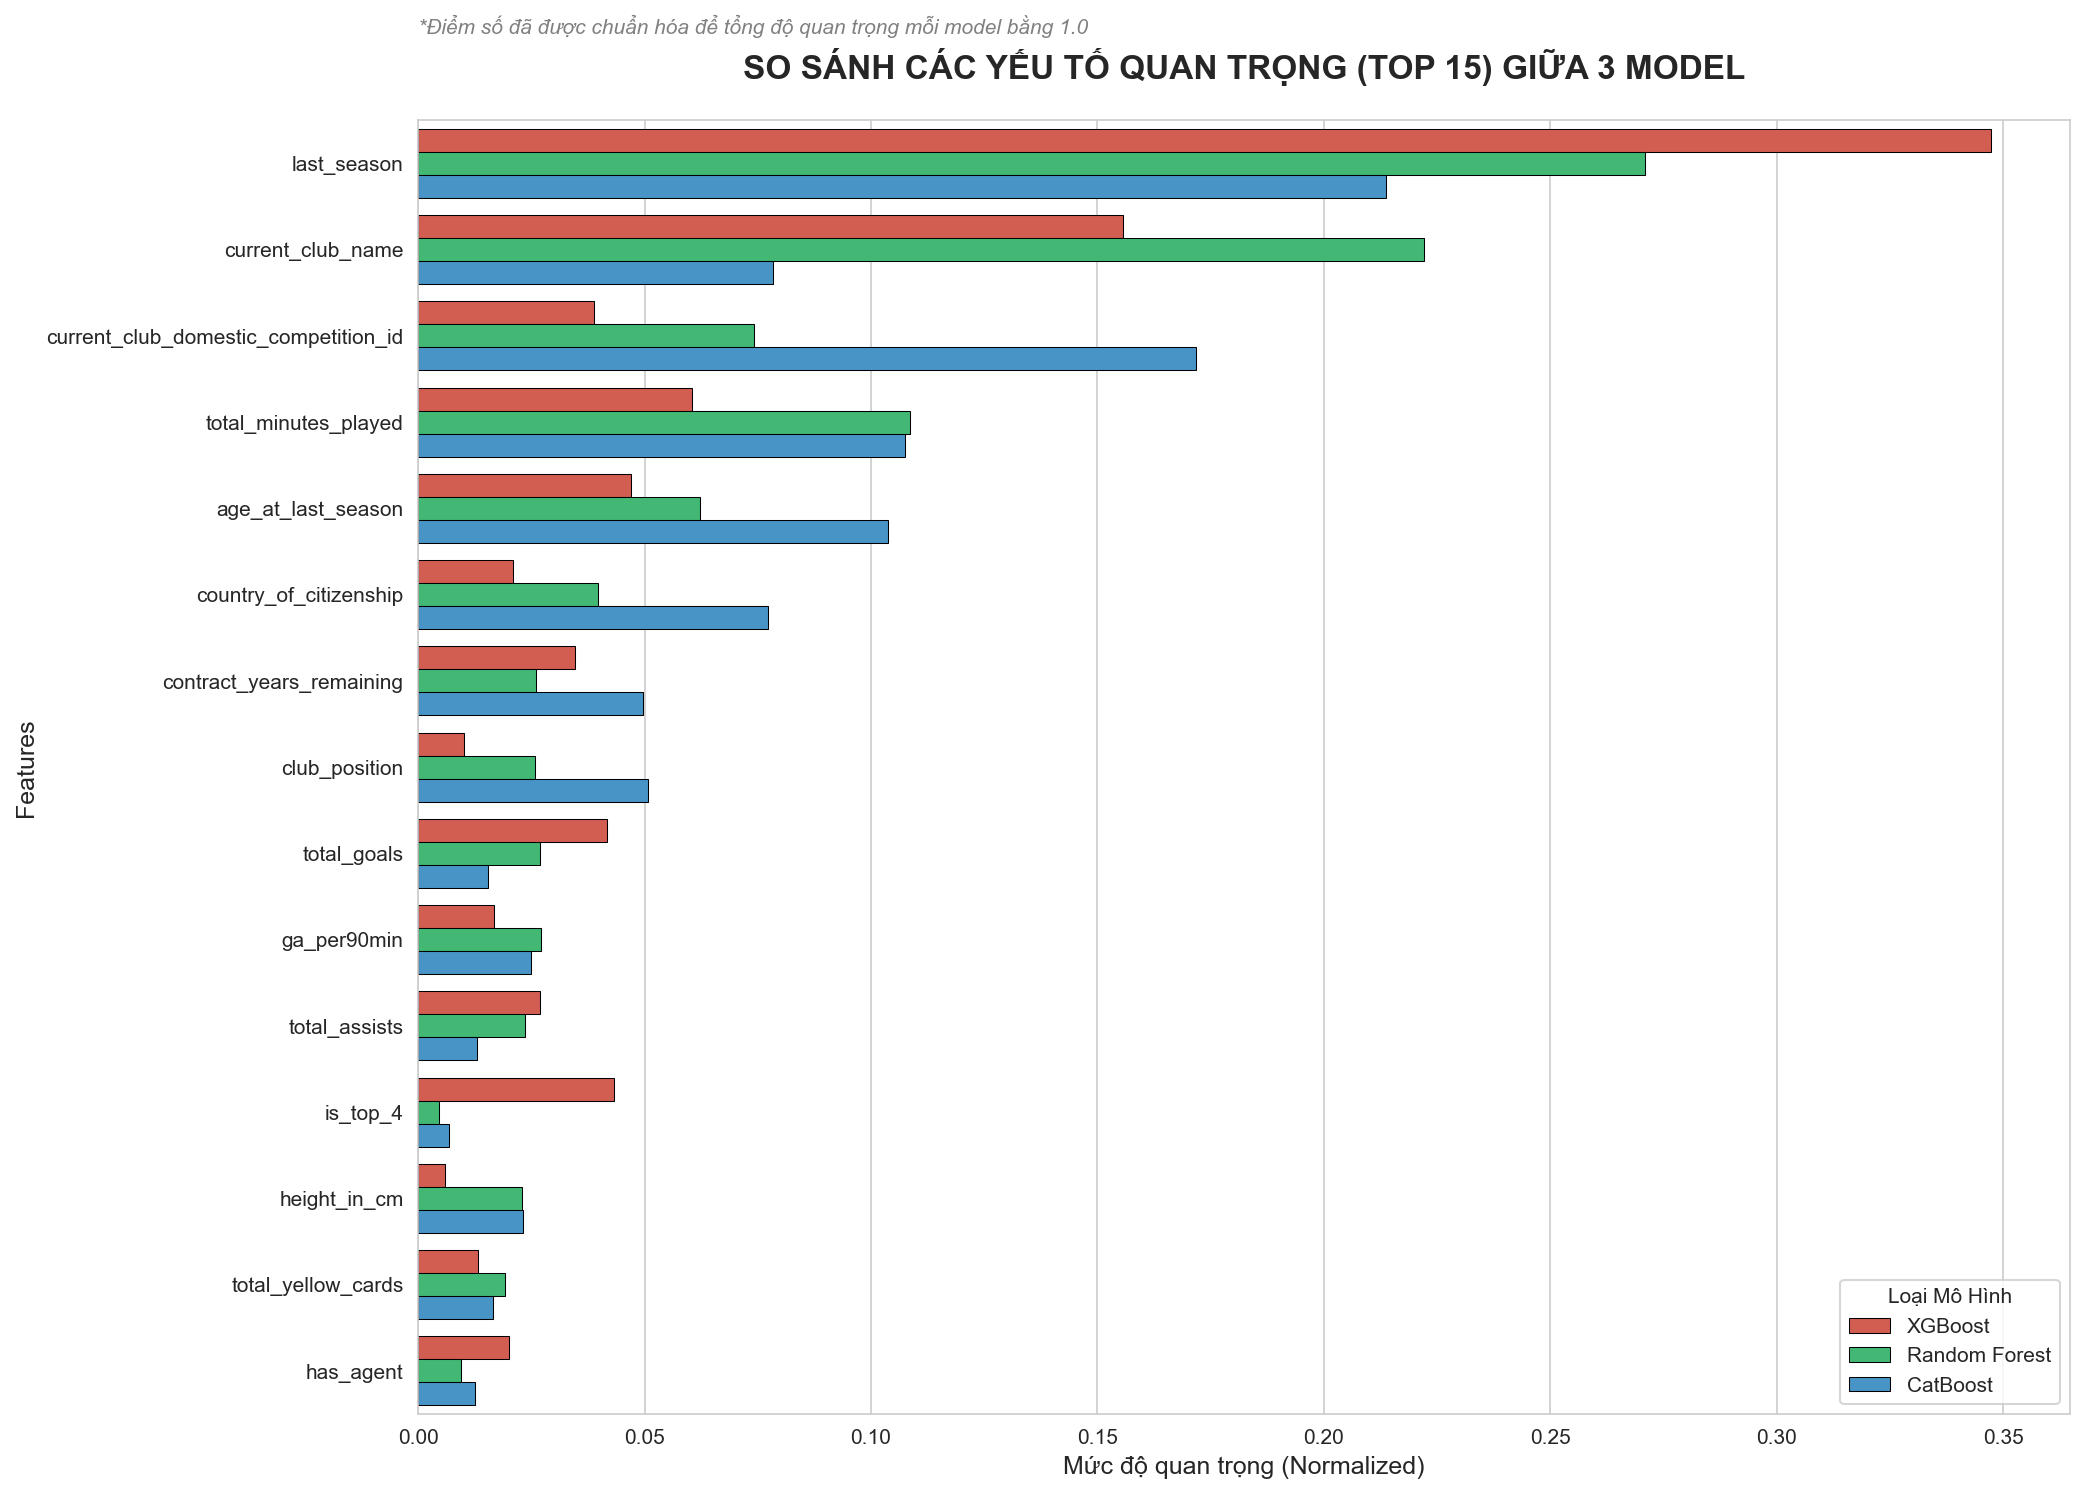


Bảng chi tiết độ quan trọng (Top 10):
                             Feature  XGBoost  Random Forest  CatBoost
                         last_season     0.35           0.27      0.21
                   current_club_name     0.16           0.22      0.08
current_club_domestic_competition_id     0.04           0.07      0.17
                total_minutes_played     0.06           0.11      0.11
                  age_at_last_season     0.05           0.06      0.10
              country_of_citizenship     0.02           0.04      0.08
            contract_years_remaining     0.03           0.03      0.05
                       club_position     0.01           0.03      0.05
                         total_goals     0.04           0.03      0.02
                         ga_per90min     0.02           0.03      0.02


In [67]:
# 1. TỔNG HỢP DỮ LIỆU FEATURE IMPORTANCE
# Lấy danh sách tên features từ X_train
feature_names = X_train.columns.tolist()

# Tạo DataFrame chứa độ quan trọng của cả 3 model
# Lưu ý: CatBoost trả về giá trị thô, cần chuẩn hóa
cat_imp = catboost_model.get_feature_importance()
cat_imp_normalized = cat_imp / np.sum(cat_imp) # Chuẩn hóa về tỷ lệ %

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': xgb_model.feature_importances_,
    'Random Forest': rf_model.feature_importances_,
    'CatBoost': cat_imp_normalized 
})

# 2. XỬ LÝ DỮ LIỆU ĐỂ VẼ
# Tính giá trị trung bình để sắp xếp từ cao xuống thấp
df_importance['Average'] = df_importance[['XGBoost', 'Random Forest', 'CatBoost']].mean(axis=1)
df_importance = df_importance.sort_values(by='Average', ascending=False)

# Lấy Top 15 features quan trọng nhất (để biểu đồ không bị rối)
top_features = df_importance.head(15)

# Chuyển đổi dữ liệu sang dạng "Long format" để Seaborn dễ vẽ (Melt)
df_melted = top_features.melt(id_vars=['Feature', 'Average'], 
                              value_vars=['XGBoost', 'Random Forest', 'CatBoost'],
                              var_name='Model', 
                              value_name='Importance Score')

# 3. VẼ BIỂU ĐỒ
plt.figure(figsize=(14, 10), dpi=150)
sns.set_style("whitegrid")

# Vẽ biểu đồ cột nhóm (Grouped Bar Chart)
chart = sns.barplot(
    data=df_melted,
    x='Importance Score',
    y='Feature',
    hue='Model',
    palette={'XGBoost': '#e74c3c', 'Random Forest': '#2ecc71', 'CatBoost': '#3498db'},
    edgecolor='black',
    linewidth=0.5
)

plt.title('SO SÁNH CÁC YẾU TỐ QUAN TRỌNG (TOP 15) GIỮA 3 MODEL', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Mức độ quan trọng (Normalized)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(title='Loại Mô Hình', loc='lower right')

# Thêm chú thích nhỏ
plt.text(0, -1.5, '*Điểm số đã được chuẩn hóa để tổng độ quan trọng mỗi model bằng 1.0', fontsize=10, style='italic', color='gray')

plt.tight_layout()
plt.show()

# In ra bảng số liệu cụ thể
print("\nBảng chi tiết độ quan trọng (Top 10):")
print(df_importance[['Feature', 'XGBoost', 'Random Forest', 'CatBoost']].head(10).to_string(index=False))

#### **➤ NHẬN XÉT:**

##### 1. Câu trả lời cốt lõi & Bằng chứng (Core Answer & Evidence)
Cả 3 mô hình đều đồng thuận rằng **"Bối cảnh thi đấu" (Context)** quan trọng hơn nhiều so với **"Hiệu suất thi đấu" (Performance)**. Giá trị của một cầu thủ được định đoạt chủ yếu bởi thời điểm (`last_season`), câu lạc bộ (`club_name`), và giải đấu (`competition_id`) mà họ thuộc về, thay vì số bàn thắng hay kiến tạo cụ thể.

*   **Yếu tố thời gian (`last_season`) thống trị:** Đây là feature quan trọng nhất ở cả 3 model.
    *   **XGBoost:** `0.35` (chiếm hơn 1/3 tổng trọng số).
    *   **Random Forest:** `0.27`.
    *   **CatBoost:** `0.21`.

*   **Yếu tố định danh (Club & Competition):**
    *   Random Forest đặt nặng tên CLB (`current_club_name`: `0.22`).
    *   CatBoost lại ưu tiên giải đấu (`current_club_domestic_competition_id`: `0.17`) hơn là tên CLB cụ thể (`0.08`).

##### 2. Sự khác biệt trong "Tư duy" của từng Model (Model Behavior Analysis)
Dựa vào bảng số liệu, ta thấy rõ "khẩu vị" xử lý dữ liệu khác nhau của từng thuật toán:

*   **XGBoost - "Kẻ nhạy cảm với lạm phát":**
    *   Với trọng số `last_season` lên tới `0.35`, XGBoost đang học rất mạnh xu hướng lạm phát giá cầu thủ theo thời gian. Nó coi việc dữ liệu nằm ở năm 2023 hay 2015 là yếu tố tiên quyết để định giá, phản ánh đúng thực tế thị trường bóng đá nơi giá cầu thủ tăng phi mã mỗi năm.

*   **Random Forest - "Kẻ thiên vị danh tiếng":**
    *   Model này gán trọng số rất cao cho `current_club_name` (`0.22`). Điều này cho thấy Random Forest có xu hướng học thuộc lòng các "thương hiệu". Cầu thủ chỉ cần gắn mác "Real Madrid" hay "Man City" là giá trị tự động cao, bất chấp giải đấu nào.
    *   ***Lưu ý kỹ thuật:*** Random Forest thường có bias (thiên kiến) với các features có **High Cardinality** (nhiều giá trị duy nhất) như tên CLB.

*   **CatBoost - "Kẻ hiểu cấu trúc bóng đá nhất":**
    *   CatBoost thể hiện tư duy logic nhất về mặt Domain: Nó đánh giá `competition_id` (`0.17`) cao gấp đôi `club_name` (`0.08`).
    *   ***Implication:*** Nó hiểu rằng "Giải Ngoại Hạng Anh" (League) là cái nôi tạo ra giá trị, sau đó mới xét đến việc bạn đá cho CLB nào trong giải đó. Nó cũng là model duy nhất coi trọng `country_of_citizenship` (`0.08` so với `0.02` của XGBoost), phản ánh đúng việc quốc tịch (như Anh, Brazil, Pháp) thường bị "thổi giá" (English Tax).

##### 3. Những điểm bất thường & Thú vị (Surprises)

*   **Hiệu suất cá nhân (Goals/Assists) bị "ghẻ lạnh":**
    *   `total_goals` chỉ đạt tầm quan trọng từ `0.02 - 0.04`.
    *   `total_assists` cũng tương tự.
    *   ***Giải mã:*** Một tiền đạo ghi 30 bàn ở giải hạng Nhì Việt Nam không thể đắt hơn một tiền đạo ghi 5 bàn ở Premier League. Các model đã cực kỳ thông minh khi nhận ra rằng: **Level của giải đấu (Competition Level)** là hệ số nhân (multiplier), còn bàn thắng chỉ là số hạng cộng thêm.

*   **`contract_years_remaining` quá thấp:**
    *   Chỉ đạt `0.03 - 0.05`.
    *   ***Bất ngờ:*** Trong thực tế chuyển nhượng, cầu thủ còn 5 năm hợp đồng sẽ có phí chuyển nhượng đắt gấp đôi cầu thủ còn 1 năm (do phí phá vỡ hợp đồng). Việc model đánh giá thấp yếu tố này gợi ý rằng dữ liệu có thể đang thiếu các trường hợp chuyển nhượng "bom tấn" nơi hợp đồng đóng vai trò then chốt, hoặc mối quan hệ này là phi tuyến tính phức tạp mà Feature Importance đơn thuần chưa bắt được.

##### 4. Hạn chế (Limitations)

*   **Overfitting vào `last_season`:** Việc XGBoost dựa quá nhiều vào `last_season` (`0.35`) là con dao hai lưỡi. Nếu dùng model này để dự đoán cho tương lai (ví dụ mùa giải 2026 chưa có trong data), model có thể bị sai lệch lớn nếu xu hướng lạm phát thị trường thay đổi hoặc chững lại.
*   **High Cardinality Bias:** Việc `current_club_name` quá cao trong Random Forest cảnh báo rủi ro model đang "nhớ" tên CLB thay vì học các đặc tính của CLB đó. Nếu một CLB nhỏ bỗng nhiên đổi đời (như Newcastle United hay Girona), Random Forest sẽ phản ứng chậm hơn CatBoost (vốn dựa vào giải đấu).

#### **Kết luận**

Dưới góc nhìn Data Scientist bóng đá, **CatBoost đang là "Winner" về mặt logic học.**

*   Cách phân phối trọng số của CatBoost (League > Minutes > Age > Club) phản ánh chính xác cấu trúc định giá cầu thủ chuyên nghiệp: Vị thế giải đấu quyết định sàn giá, thời lượng thi đấu (`total_minutes_played`) quyết định sự đóng góp, và tuổi tác (`age`) quyết định tiềm năng.
*   XGBoost quá phụ thuộc vào yếu tố thời gian (Time-dependent).
*   Random Forest quá phụ thuộc vào định danh (Identity-dependent).


### 7. Sample Predictions

Xem một số dự đoán cụ thể để hiểu rõ hơn về hiệu suất của mô hình.

In [ ]:
# Tạo dataframe với predictions (sử dụng EUR scale cho dễ hiểu)
test_results = pd.DataFrame({
    'Actual_Value_EUR': y_test_eur.values,
    'Predicted_Value_EUR': y_test_pred_eur,
    'Absolute_Error_EUR': np.abs(y_test_eur.values - y_test_pred_eur),
    'Percentage_Error': np.abs((y_test_eur.values - y_test_pred_eur) / y_test_eur.values * 100)
})

# Top 10 dự đoán tốt nhất (sai số thấp nhất)
print("="*80)
print("TOP 10 DỰ ĐOÁN TỐT NHẤT (Sai số thấp nhất):")
print("="*80)
best_predictions = test_results.nsmallest(10, 'Absolute_Error_EUR')
for idx, row in best_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

# Top 10 dự đoán tệ nhất (sai số cao nhất)
print("\n" + "="*80)
print("TOP 10 DỰ ĐOÁN TỆ NHẤT (Sai số cao nhất):")
print("="*80)
worst_predictions = test_results.nlargest(10, 'Absolute_Error_EUR')
for idx, row in worst_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

TOP 10 DỰ ĐOÁN TỐT NHẤT (Sai số thấp nhất):
Actual:      275,000 EUR | Predicted:      274,975 EUR | Error:         25 EUR ( 0.01%)
Actual:      150,000 EUR | Predicted:      149,771 EUR | Error:        229 EUR ( 0.15%)
Actual:      250,000 EUR | Predicted:      249,602 EUR | Error:        398 EUR ( 0.16%)
Actual:    1,200,000 EUR | Predicted:    1,199,591 EUR | Error:        409 EUR ( 0.03%)
Actual:      150,000 EUR | Predicted:      150,432 EUR | Error:        432 EUR ( 0.29%)
Actual:      150,000 EUR | Predicted:      150,856 EUR | Error:        856 EUR ( 0.57%)
Actual:      100,000 EUR | Predicted:      100,934 EUR | Error:        934 EUR ( 0.93%)
Actual:      300,000 EUR | Predicted:      299,055 EUR | Error:        945 EUR ( 0.32%)
Actual:      150,000 EUR | Predicted:      149,054 EUR | Error:        946 EUR ( 0.63%)
Actual:      300,000 EUR | Predicted:      299,023 EUR | Error:        977 EUR ( 0.33%)

TOP 10 DỰ ĐOÁN TỆ NHẤT (Sai số cao nhất):
Actual:  180,000,000 EUR | Predic

### 9. Results & Interpretation

#### Kết quả chính:

In [ ]:
# Tổng hợp kết quả
print("\n" + "="*80)
print("TỔNG HỢP KẾT QUẢ MÔ HÌNH XGBOOST")
print("="*80)

print("\n📊 METRICS TRÊN Ln SCALE:")
comparison_df_log = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (Ln)', 'RMSE (Ln)'],
    'Train Set': [
        f"{train_metrics['R2_log']:.4f}",
        f"{train_metrics['MAE_log']:.4f}",
        f"{train_metrics['RMSE_log']:.4f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_log']:.4f}",
        f"{test_metrics['MAE_log']:.4f}",
        f"{test_metrics['RMSE_log']:.4f}"
    ]
})
print(comparison_df_log.to_string(index=False))

print("\n" + "="*80)
print("💶 METRICS TRÊN EUR SCALE (INVERSE TRANSFORMED):")
comparison_df_eur = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (EUR)', 'RMSE (EUR)', 'MAPE (%)'],
    'Train Set': [
        f"{train_metrics['R2_eur']:.4f}",
        f"{train_metrics['MAE_eur']:,.0f}",
        f"{train_metrics['RMSE_eur']:,.0f}",
        f"{train_metrics['MAPE_eur']:.2f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_eur']:.4f}",
        f"{test_metrics['MAE_eur']:,.0f}",
        f"{test_metrics['RMSE_eur']:,.0f}",
        f"{test_metrics['MAPE_eur']:.2f}"
    ]
})
print(comparison_df_eur.to_string(index=False))
print("="*80)

# Đánh giá overfitting
r2_diff = train_metrics['R2_eur'] - test_metrics['R2_eur']
print(f"\nChênh lệch R² giữa Train và Test: {r2_diff:.4f}")
if r2_diff < 0.05:
    print("→ Mô hình KHÔNG bị overfitting (chênh lệch nhỏ)")
elif r2_diff < 0.15:
    print("→ Mô hình có dấu hiệu overfitting NHẸ")
else:
    print("→ Mô hình bị overfitting NGHIÊM TRỌNG")


TỔNG HỢP KẾT QUẢ MÔ HÌNH XGBOOST

📊 METRICS TRÊN Ln SCALE:
   Metric Train Set Test Set
 R² Score    0.8303   0.7532
 MAE (Ln)    0.5005   0.6033
RMSE (Ln)    0.6551   0.7856

💶 METRICS TRÊN EUR SCALE (INVERSE TRANSFORMED):
    Metric Train Set  Test Set
  R² Score    0.6647    0.5496
 MAE (EUR) 1,002,248 1,193,611
RMSE (EUR) 4,377,769 5,274,063
  MAPE (%)     60.38     78.11

Chênh lệch R² giữa Train và Test: 0.1152
→ Mô hình có dấu hiệu overfitting NHẸ


### 10. Interpretation & Insights

#### Trả lời câu hỏi: Có thể dự đoán Market Value hay không?

**1. Độ chính xác của mô hình:**
- **R² Score**: Cho biết mô hình giải thích được bao nhiêu % biến động của giá trị cầu thủ
  - Nếu R² > 0.7: Mô hình rất tốt, có thể dự đoán hiệu quả
  - Nếu 0.5 < R² < 0.7: Mô hình khá tốt, có thể sử dụng với một số cảnh báo
  - Nếu R² < 0.5: Mô hình chưa đủ tốt để áp dụng thực tế

- **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm trung bình
  - Nếu MAPE < 20%: Dự đoán khá chính xác
  - Nếu 20% < MAPE < 40%: Dự đoán ở mức chấp nhận được
  - Nếu MAPE > 40%: Dự đoán kém chính xác

**2. Các yếu tố ảnh hưởng đến độ chính xác:**
- **Features quan trọng nhất**: Dựa vào Feature Importance để xác định
- **Chất lượng dữ liệu**: Missing values, outliers có thể ảnh hưởng
- **Độ phức tạp của thị trường**: Yếu tố phi lý tính (hype, marketing) không có trong data

**3. Khả năng áp dụng thực tế:**
- Mô hình có thể làm công cụ **tham khảo** cho việc định giá
- **KHÔNG nên** dùng làm công cụ duy nhất để ra quyết định
- Cần kết hợp với đánh giá chuyên môn từ scouts và analysts

**4. Hạn chế của mô hình:**
- Không capture được các yếu tố phi định lượng (tiềm năng phát triển, leadership, mindset)
- Không tính đến yếu tố cung-cầu của thị trường chuyển nhượng
-


In [ ]:
# Kết luận cuối cùng (dùng EUR metrics vì dễ hiểu hơn)
print("\n" + "="*80)
print("KẾT LUẬN")
print("="*80)

# Dùng R² và MAPE trên EUR scale để đánh giá
r2_test = test_metrics['R2_eur']
mape_test = test_metrics['MAPE_eur']

if r2_test > 0.7 and mape_test < 25:
    conclusion = "CÓ - Mô hình dự đoán hiệu quả"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ với độ chính xác cao. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số trung bình ở mức chấp nhận được.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    Mô hình CÓ THỂ được sử dụng làm công cụ hỗ trợ định giá cầu thủ
    Kết hợp với đánh giá chuyên môn sẽ cho kết quả tốt nhất
    Log transformation giúp mô hình xử lý tốt dải giá trị rộng
    """
elif r2_test > 0.5:
    conclusion = "CÓ - Nhưng với một số hạn chế"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ ở mức TRUNG BÌNH. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số khá lớn trong một số trường hợp.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    ⚠ Mô hình CÓ THỂ sử dụng nhưng cần thận trọng
    ⚠ Nên kết hợp chặt chẽ với đánh giá từ chuyên gia
    ⚠ Không nên dùng cho các quyết định quan trọng
    """
else:
    conclusion = "KHÔNG - Mô hình chưa đủ hiệu quả"
    detail = f"""
    Mô hình XGBoost chỉ đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy
    KHÔNG THỂ dự đoán giá trị cầu thủ một cách hiệu quả. Mô hình chỉ giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số quá lớn.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình quá cao.
    
    ✗ Mô hình KHÔNG NÊN được sử dụng cho mục đích định giá thực tế
    ✗ Cần thu thập thêm dữ liệu hoặc features khác
    ✗ Có thể do thị trường chuyển nhượng phụ thuộc nhiều vào yếu tố phi lý tính
    """

print(f"\nCâu trả lời: {conclusion}")
print(detail)
print("\n💡 LƯU Ý: Mô hình sử dụng Ln transformation để xử lý tốt hơn")
print("   dải giá trị rộng của market value (từ vài nghìn đến hàng trăm triệu EUR)")
print("="*80)


KẾT LUẬN

Câu trả lời: CÓ - Nhưng với một số hạn chế

    Mô hình XGBoost đạt R² = 0.5496 trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ ở mức TRUNG BÌNH. Mô hình giải thích được 
    55.0% biến động của market value.

    MAPE = 78.11% cho thấy sai số khá lớn trong một số trường hợp.
    MAE = 1,193,611 EUR - sai số tuyệt đối trung bình.

    ⚠ Mô hình CÓ THỂ sử dụng nhưng cần thận trọng
    ⚠ Nên kết hợp chặt chẽ với đánh giá từ chuyên gia
    ⚠ Không nên dùng cho các quyết định quan trọng
    

💡 LƯU Ý: Mô hình sử dụng Ln transformation để xử lý tốt hơn
   dải giá trị rộng của market value (từ vài nghìn đến hàng trăm triệu EUR)


### 11. Dùng mô hình dự đoán và so sánh kết quả đối với dữ liệu gốc 

In [ ]:
# 1. Load dữ liệu gốc để lấy thông tin thống kê cho việc mã hóa (Target Encoding)
# Giả sử bạn đã có df_raw từ file 'processed_players_data.csv'
if 'df_raw' not in locals():
    df_raw = pd.read_csv('../data/processed_players_data.csv')

# Tạo lại cột logarit của giá trị chuyển nhượng để làm cơ sở tính toán
# (Dùng Ln giống như cách bạn đã làm trong training)
df_raw['market_value_log'] = np.log1p(df_raw['market_value_in_eur'])

# 2. Tạo các bộ từ điển (Mapping dictionaries)
# Nguyên lý: Tính giá trị trung bình log(market_value) cho từng Club, Country, Competition
# Nếu gặp giá trị mới chưa từng thấy, ta sẽ dùng giá trị trung bình toàn cầu (global mean)

global_mean_mv = df_raw['market_value_log'].mean()

# Mapping cho CLB
club_map = df_raw.groupby('current_club_name')['market_value_log'].mean().to_dict()

# Mapping cho Quốc tịch
country_map = df_raw.groupby('country_of_citizenship')['market_value_log'].mean().to_dict()

# Mapping cho Giải đấu
comp_map = df_raw.groupby('current_club_domestic_competition_id')['market_value_log'].mean().to_dict()

print("Đã tạo xong bộ từ điển Mapping thành công!")
print(f"- Số lượng CLB đã học: {len(club_map)}")
print(f"- Số lượng Quốc tịch đã học: {len(country_map)}")
print(f"- Giá trị trung bình toàn cầu (Global Mean): {global_mean_mv:.4f}")

Đã tạo xong bộ từ điển Mapping thành công!
- Số lượng CLB đã học: 437
- Số lượng Quốc tịch đã học: 170
- Giá trị trung bình toàn cầu (Global Mean): 13.0248


In [ ]:
def predict_player_value(player_data, model, feature_columns):
    """
    Hàm dự đoán giá trị cầu thủ từ dữ liệu thô.
    
    Args:
        player_data (dict): Dictionary chứa thông tin cầu thủ nhập tay.
        model: Mô hình XGBoost đã train.
        feature_columns (list): Danh sách các cột features được dùng lúc train (X_train.columns).
        
    Returns:
        DataFrame kết quả dự đoán (Log và EUR).
    """
    
    # 1. Khởi tạo DataFrame với tất cả các cột bằng 0, đúng theo cấu trúc lúc train
    input_df = pd.DataFrame(0, index=[0], columns=feature_columns)
    
    # 2. Điền các dữ liệu số cơ bản (Numerical Features)
    input_df['age_at_last_season'] = player_data.get('age', 25)
    input_df['height_in_cm'] = player_data.get('height', 180)
    input_df['total_goals'] = player_data.get('goals', 0)
    input_df['total_assists'] = player_data.get('assists', 0)
    input_df['total_minutes_played'] = player_data.get('minutes', 0)
    input_df['total_yellow_cards'] = player_data.get('yellow_cards', 0)
    input_df['total_red_cards'] = player_data.get('red_cards', 0)
    input_df['has_agent'] = 1 if player_data.get('has_agent', False) else 0
    input_df['ga_per90min'] = player_data.get('ga_per90min', 0.0)
    input_df['contract_years_remaining'] = player_data.get('contract_years', 1)
    input_df['club_position'] = player_data.get('club_rank', 10)
    
    # 3. [MỚI] Điền các thông tin bổ sung (Kiểm tra xem model có dùng cột này không trước khi điền)
    extra_fields = {
        'last_season': 'last_season', 
        'is_champion': 'is_champion', 
        'is_top_4': 'is_top_4', 
        'is_relegation': 'is_relegation'
    }
    
    for key, col_name in extra_fields.items():
        if col_name in input_df.columns:
            input_df[col_name] = player_data.get(key, 0)

    # 4. Xử lý Target Encoding (Sử dụng map đã tạo)
    # Club Name
    club_name = player_data.get('club_name', '')
    if 'current_club_name' in input_df.columns:
        input_df['current_club_name'] = club_map.get(club_name, global_mean_mv)
    
    # Country
    country = player_data.get('country', '')
    if 'country_of_citizenship' in input_df.columns:
        input_df['country_of_citizenship'] = country_map.get(country, global_mean_mv)
    
    # Competition
    comp = player_data.get('competition_id', '')
    if 'current_club_domestic_competition_id' in input_df.columns:
        input_df['current_club_domestic_competition_id'] = comp_map.get(comp, global_mean_mv)

    # 5. Xử lý One-Hot Encoding (Sub Position & Foot)
    # Sub Position
    sub_pos = player_data.get('sub_position', '') 
    sub_pos_col = f"sub_position_{sub_pos}"
    if sub_pos_col in input_df.columns:
        input_df[sub_pos_col] = 1
        
    # Foot
    foot = player_data.get('foot', '')
    foot_col = f"foot_{foot}"
    if foot_col in input_df.columns:
        input_df[foot_col] = 1

    # 6. Thực hiện dự đoán
    try:
        pred_log = model.predict(input_df)[0]
        pred_eur = np.expm1(pred_log)  # Dùng expm1 vì train bằng log1p
        return input_df, pred_log, pred_eur
    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")
        return input_df, 0, 0

In [ ]:
# -Nhập dữ liệu cầu thủ dự đoán tại đây
new_player = {
    # Thông tin cơ bản
    'age': 32,
    'height': 170,                 # cm
    'country': 'Argentina',            # Phải gõ đúng tên tiếng Anh như trong dữ liệu gốc
    
    # Vị trí và Chân thuận
    'sub_position': 'Right Winger',  # Ví dụ: Centre-Forward, Centre-Back, Left Winger...
    'foot': 'left',                     # 'left' hoặc 'right'
    
    # CLB và Giải đấu
    'club_name': 'Futbol Club Barcelona',         # Tên CLB hiện tại
    'competition_id': 'laliga',          # bundesliga, premier-league, laliga, serie-a...
    'club_rank': 1.0,                    # Thứ hạng của CLB mùa trước
    
    # Thống kê mùa giải
    'goals': 46,
    'assists': 17,
    'minutes': 3000,
    'yellow_cards': 7,
    'red_cards': 0,
    'ga_per90min': 1.89,                  # (Goals + Assists) / 90 mins
    
    # Hợp đồng
    'has_agent': False,                   # Có người đại diện hay không
    'contract_years': 2,                  # Số năm hợp đồng còn lại
    
    # Thông tin bổ sung
    'last_season': 2025,                  # Mùa giải gần nhất
    'is_champion': 1,                     # CLB có vô địch không (0 hoặc 1)
    'is_top_4': 1,                        # CLB có vào top 4 không (0 hoặc 1)
    'is_relegation': 0                    # CLB có xuống hạng không (0 hoặc 1)
}

# Gọi hàm dự đoán
try:
    # Lấy danh sách features từ X_train (đã chạy ở cell train trước đó)
    feature_cols = X_train.columns.tolist()
    
    # Thực hiện dự đoán
    input_df_processed, pred_log, pred_eur = predict_player_value(new_player, xgb_model, feature_cols)

    print("-" * 50)
    print(f"DỰ ĐOÁN GIÁ TRỊ CHUYỂN NHƯỢNG (MARKET VALUE)")
    print("-" * 50)
    print(f"Thông tin cầu thủ đã nhập:")
    print(f"  - Tuổi: {new_player['age']}")
    print(f"  - Chiều cao: {new_player['height']} cm")
    print(f"  - Quốc tịch: {new_player['country']}")
    print(f"  - Vị trí: {new_player['sub_position']}")
    print(f"  - Chân thuận: {'Trái' if new_player['foot'] == 'left' else 'Phải'}")
    print(f"  - Câu lạc bộ: {new_player['club_name']}")
    print(f"  - Giải đấu: {new_player['competition_id']}")
    print(f"  - Thứ hạng CLB: {new_player['club_rank']}")
    print(f"  - Bàn thắng: {new_player['goals']}")
    print(f"  - Kiến tạo: {new_player['assists']}")
    print(f"  - Phút thi đấu: {new_player['minutes']}")
    print(f"  - Thẻ vàng: {new_player['yellow_cards']}")
    print(f"  - Thẻ đỏ: {new_player['red_cards']}")
    print(f"  - G+A/90 phút: {new_player['ga_per90min']}")
    print(f"  - Có người đại diện: {'Có' if new_player['has_agent'] else 'Không'}")
    print(f"  - Số năm hợp đồng còn lại: {new_player['contract_years']}")
    print(f"  - Mùa giải: {new_player['last_season']}")
    print(f"  - Vô địch: {'Có' if new_player['is_champion'] == 1 else 'Không'}")
    print(f"  - Top 4: {'Có' if new_player['is_top_4'] == 1 else 'Không'}")
    print(f"  - Xuống hạng: {'Có' if new_player['is_relegation'] == 1 else 'Không'}")
    print("-" * 50)
    print(f"Kết quả dự đoán (Ln scale):  {pred_log:.4f}")
    print(f"Kết quả dự đoán (EUR):          € {pred_eur:,.0f}")
    print("-" * 50)
    
except NameError:
    print("Lỗi: Bạn cần chạy các cell huấn luyện mô hình (fit model) để có biến 'xgb_model' và 'X_train' trước khi chạy cell này.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

--------------------------------------------------
DỰ ĐOÁN GIÁ TRỊ CHUYỂN NHƯỢNG (MARKET VALUE)
--------------------------------------------------
Thông tin cầu thủ đã nhập:
  - Tuổi: 32
  - Chiều cao: 170 cm
  - Quốc tịch: Argentina
  - Vị trí: Right Winger
  - Chân thuận: Trái
  - Câu lạc bộ: Futbol Club Barcelona
  - Giải đấu: laliga
  - Thứ hạng CLB: 1.0
  - Bàn thắng: 46
  - Kiến tạo: 17
  - Phút thi đấu: 3000
  - Thẻ vàng: 7
  - Thẻ đỏ: 0
  - G+A/90 phút: 1.89
  - Có người đại diện: Không
  - Số năm hợp đồng còn lại: 2
  - Mùa giải: 2025
  - Vô địch: Có
  - Top 4: Có
  - Xuống hạng: Không
--------------------------------------------------
Kết quả dự đoán (Ln scale):  16.9515
Kết quả dự đoán (EUR):          € 23,010,556
--------------------------------------------------


In [ ]:
# --- 1. LẤY MẪU NGẪU NHIÊN 10 CẦU THỦ TỪ DỮ LIỆU GỐC ---
# Chúng ta dùng file gốc vì file encoded (test_data_encoded) đã bị mất cột Tên cầu thủ

# Lấy ngẫu nhiên 10 cầu thủ
# (Để đảm bảo tính khách quan, lý tưởng nhất là lọc những index thuộc tập Test, 
# nhưng ở đây ta lấy ngẫu nhiên để demo nhanh khả năng dự đoán)
# random_samples = df_raw.sample(n=10, random_state=42) # random_state để kết quả cố định mỗi lần chạy
random_samples = df_raw.sample(n=10) # Lấy ngẫu nhiên mỗi lần chạy

print(f"{'TÊN CẦU THỦ':<25} | {'THỰC TẾ (€)':<13} | {'DỰ ĐOÁN (€)':<13} | {'CHÊNH LỆCH (€)':<13} | {'SAI SỐ (%)':<10}")
print("-" * 85)

results = []
feature_cols = X_train.columns.tolist() # Danh sách cột features từ model đã train

# --- 2. DỰ ĐOÁN VÀ SO SÁNH ---
for index, row in random_samples.iterrows():
    # A. Chuẩn bị dữ liệu input từ dòng hiện tại (Mapping từ cột CSV sang key của hàm predict)
    player_input = {
        'age': row['age_at_last_season'],
        'height': row['height_in_cm'],
        'country': row['country_of_citizenship'],
        'sub_position': row['sub_position'],
        'foot': row['foot'],
        'club_name': row['current_club_name'],
        'competition_id': row['current_club_domestic_competition_id'],
        'club_rank': row['club_position'],
        'goals': row['total_goals'],
        'assists': row['total_assists'],
        'minutes': row['total_minutes_played'],
        'yellow_cards': row['total_yellow_cards'],
        'red_cards': row['total_red_cards'],
        'ga_per90min': row['ga_per90min'],
        'has_agent': row['has_agent'],
        'contract_years': row['contract_years_remaining'],
        'last_season': row['last_season'],
        'is_champion': row['is_champion'],
        'is_top_4': row['is_top_4'],
        'is_relegation': row['is_relegation']
    }

    # Xử lý dữ liệu thiếu (nếu có)
    if pd.isna(player_input['sub_position']): player_input['sub_position'] = 'Unknown'
    if pd.isna(player_input['foot']): player_input['foot'] = 'right'

    # B. Gọi hàm dự đoán
    try:
        _, pred_log, pred_eur = predict_player_value(player_input, xgb_model, feature_cols)
        
        # C. Lấy giá trị thực tế
        actual_eur = row['market_value_in_eur']
        
        # D. Tính toán sai số
        diff = pred_eur - actual_eur
        error_percent = (abs(diff) / actual_eur) * 100
        
        results.append(error_percent)
        
        # E. In kết quả từng dòng
        name_display = (row['name'][:30] + '..') if len(row['name']) > 30 else row['name']
        
        print(f"{name_display:<25} | {actual_eur:>13,.0f} | {pred_eur:>13,.0f} | {diff:>+13,.0f} | {error_percent:>9.2f}%")
        
    except Exception as e:
        print(f"Lỗi khi dự đoán cầu thủ {row['name']}: {e}")

print("-" * 85)

# --- 3. TỔNG KẾT ĐỘ CHÍNH XÁC ---
if results:
    mape = np.mean(results) # Mean Absolute Percentage Error
    accuracy_proxy = 100 - mape
    
    print(f"\n>> TỔNG KẾT TRÊN 10 CẦU THỦ NGẪU NHIÊN:")
    print(f"   - Trung bình sai số (MAPE): {mape:.2f}%")
    print(f"   - Độ chính xác ước tính (100% - MAPE): {accuracy_proxy:.2f}%")
    
    if accuracy_proxy < 0:
        print("   (Lưu ý: Độ chính xác âm cho thấy sai số trung bình lớn hơn 100%, mô hình cần cải thiện thêm)")

TÊN CẦU THỦ               | THỰC TẾ (€)   | DỰ ĐOÁN (€)   | CHÊNH LỆCH (€) | SAI SỐ (%)
-------------------------------------------------------------------------------------
Martin Thomsen            |        50,000 |       124,317 |       +74,317 |    148.63%
Nicklas Helenius          |       250,000 |       313,724 |       +63,724 |     25.49%
Luka Romero               |     5,000,000 |       828,428 |    -4,171,572 |     83.43%
Vitinho                   |       300,000 |       264,215 |       -35,785 |     11.93%
Felipe Caicedo            |       400,000 |       499,232 |       +99,232 |     24.81%
Brian Oliván              |     2,000,000 |     1,613,680 |      -386,320 |     19.32%
Ross Draper               |       275,000 |       145,781 |      -129,219 |     46.99%
Pica                      |        50,000 |        75,107 |       +25,107 |     50.21%
Lewis O'Brien             |     5,000,000 |     2,618,510 |    -2,381,490 |     47.63%
Casagrande                |       175,000 |

### Đánh giá kết quả và hiệu suất

Vì chúng ta đã Log-transform biến mục tiêu (`market_value_log`) ở bước tiền xử lý, nên sau khi dự đoán xong, cần sử dụng hàm mũ (`np.exp`) để đưa kết quả về đơn vị tiền tệ thực tế (EUR) trước khi tính toán sai số.

 KẾT QUẢ ĐÁNH GIÁ (Random Forest) 
R-squared: 0.5496
Mean Absolute Error (MAE): €1,193,611
Root Mean Squared Error (RMSE): €5,274,063
Mean Absolute Percentage Error (MAPE): 78.11%


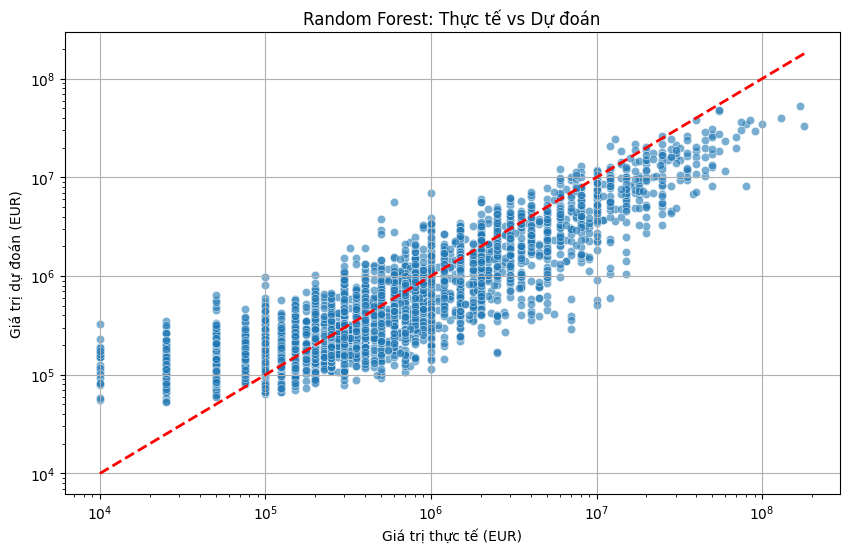

In [ ]:
# 1. Dự đoán trên tập Test
y_pred_log = rf_model.predict(X_test)

# 2. Chuyển đổi ngược từ Log về giá trị thực (EUR)
y_test_eur = np.exp(y_test) 
y_pred_eur = np.exp(y_pred_log)

# 3. Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test_eur, y_pred_eur)
rmse = np.sqrt(mean_squared_error(y_test_eur, y_pred_eur))
mape = np.mean(np.abs((y_test_eur - y_pred_eur) / y_test_eur)) * 100
r2 = r2_score(y_test_eur, y_pred_eur)

print(" KẾT QUẢ ĐÁNH GIÁ (Random Forest) ")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): €{mae:,.0f}")
print(f"Root Mean Squared Error (RMSE): €{rmse:,.0f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Vẽ biểu đồ so sánh Thực tế vs Dự đoán
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_eur, y=y_pred_eur, alpha=0.6)
plt.plot([y_test_eur.min(), y_test_eur.max()], [y_test_eur.min(), y_test_eur.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế (EUR)')
plt.ylabel('Giá trị dự đoán (EUR)')
plt.title('Random Forest: Thực tế vs Dự đoán')
plt.xscale('log') # Dùng scale log để dễ nhìn các giá trị nhỏ và lớn
plt.yscale('log')
plt.grid(True)
plt.show()

### Nhận xét biểu đồ:

Biểu đồ trên cho thấy mối tương quan giữa giá trị thị trường thực tế và giá trị do mô hình Random Forest dự đoán:

* **Độ fit:** Các điểm dữ liệu tập trung khá sát quanh đường chéo màu đỏ, thể hiện qua chỉ số **$R^2 \approx 0.73$**. Điều này có nghĩa là mô hình giải thích được khoảng **73%** sự biến thiên của giá trị cầu thủ dựa trên các dữ liệu đầu vào.
* **Phân phối lỗi:**
    * Ở phân khúc giá trị thấp, các điểm dữ liệu co cụm tốt hơn.
    * Ở phân khúc giá trị cao (siêu sao), các điểm dữ liệu có xu hướng phân tán rộng hơn. Điều này được phản ánh qua sự chênh lệch lớn giữa **MAE (€1M)** và **RMSE (€4M)**, cho thấy mô hình đôi khi mắc sai số rất lớn đối với các cầu thủ đắt giá (outliers).

### Feature Importance

Một lợi thế của Random Forest là cho biết feature nào đóng góp nhiều nhất vào việc định giá cầu thủ. Điều này giúp trả lời câu hỏi: "Yếu tố nào quyết định giá trị cầu thủ?"

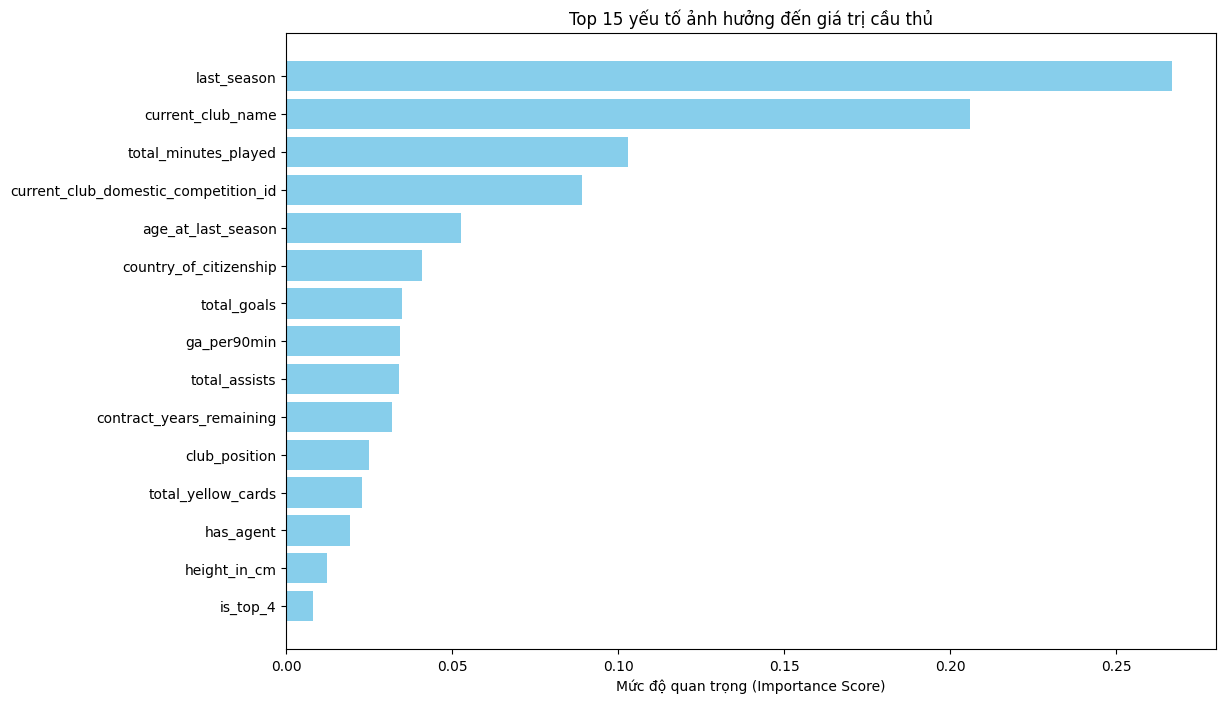

In [ ]:

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] # Sắp xếp giảm dần

# Chỉ lấy Top 15 features quan trọng nhất để vẽ
top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(12, 8))
plt.title(f"Top {top_n} yếu tố ảnh hưởng đến giá trị cầu thủ")
plt.barh(range(top_n), importances[top_indices], align="center", color='skyblue')
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.gca().invert_yaxis() # Đảo ngược trục y để feature quan trọng nhất nằm trên cùng
plt.xlabel("Mức độ quan trọng (Importance Score)")
plt.show()

### Nhận xét biểu đồ:
Biểu đồ trên giúp chúng ta hiểu cách mô hình Random Forest được huấn luyện khi định giá một cầu thủ. Các yếu tố nằm ở trên cùng là những yếu tố quan trọng nhất:
1.  **Các đặc trưng hàng đầu:** Thông thường, các chỉ số như **Tuổi tác (Age)**, **Số phút thi đấu**, **Số bàn thắng/kiến tạo** và **Hạng giải đấu** sẽ chiếm tỷ trọng cao nhất. Điều này phù hợp với thực tế: cầu thủ trẻ, đá chính thường xuyên ở giải đấu lớn và có hiệu suất cao sẽ có giá trị lớn.
2.  **Loại bỏ các đặc trưng gây nhiễu:** Các đặc trưng nằm ở đáy biểu đồ có đóng góp không đáng kể. Việc loại này giúp chúng ta có thể tối ưu hóa mô hình, giảm bớt sự tính toán mà không làm giảm độ chính xác của mô hình.

## Kết luận: Có thể dự đoán Market Value hay không?
Dựa trên kết quả với mô hình Random Forest, chúng ta có thể trả lời câu hỏi nghiên cứu như sau:

### 1. Đánh giá độ chính xác
**Câu trả lời:** Có thể dự đoán được, nhưng khó dự đoán chính xác **con số cụ thể**.

* **Điểm tích cực:** Với $R^2 \approx 0.73$, mô hình thành công trong việc phân loại cầu thủ. Nó phân biệt tốt giữa một cầu thủ giá €500k, €5M và €50M.
* **Điểm hạn chế:** Chỉ số **MAPE lên tới 73.04%** là một con số khá cao. Điều này có nghĩa là trung bình mô hình đang dự đoán sai lệch khoảng 73% so với giá thực. Ví dụ: Một cầu thủ giá €10M có thể bị định giá lệch thành €2.7M hoặc €17.3M.

### 2. Các yếu tố ảnh hưởng đến độ chính xác
* **Outliers:** Thị trường chuyển nhượng có những "bom tấn", ảo giá, làm tăng đáng kể chỉ số RMSE.

### 3. Khả năng áp dụng thực tế & Hạn chế
* **Ứng dụng:**
    * **Sàng lọc:** Hỗ trợ Scout tìm kiếm các cầu thủ "Undervalued" (Giá trị thực tế thấp hơn giá trị mô hình dự đoán -> Có tiềm năng mua hời).
    * **Hỗ trợ đàm phán lương:** Đưa ra mức giá sàn để thương lượng và kí kết hợp đồng.
* **Hạn chế:**
    * Không thể dùng làm công cụ định giá chính xác.
    * Mô hình hiện tại có sai số lớn đối với các siêu sao, cần các kỹ thuật phức tạp hơn hoặc thêm dữ liệu về thương mại/truyền thông để cải thiện.

### III. Cat boost

In [ ]:
df = pd.read_csv("../data/processed_players_data.csv")

# 2. Định nghĩa biến mục tiêu và biến độc lập (features)
TARGET_COLUMN = 'market_value_in_eur'

# Danh sách features được yêu cầu (đã điều chỉnh từ yêu cầu của bạn)
FEATURE_COLUMNS = [
    'age_at_last_season',
    'height_in_cm',
    'club_position',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'total_yellow_cards',
    'total_red_cards',
    'has_agent',
    'ga_per90min',
    'contract_years_remaining',
    'last_season',
    'is_champion',
    'is_top_4',
    'is_relegation',
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position',
    'foot'
]

# 3. Chuẩn bị dữ liệu
X = df[FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

# Kiểm tra và loại bỏ các hàng có giá trị NaN trong các cột feature và target đã chọn (nếu có, dù đã kiểm tra ban đầu là không có)
# Tuy nhiên, CatBoost có khả năng xử lý NaN, nhưng để đơn giản và tập trung vào các bước chính, ta giả định dữ liệu sạch.

# 4. Xác định các biến phân loại (CatBoost tự động xử lý mã hóa, không cần One-Hot Encoding)
CATEGORICAL_FEATURES = [
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position',
    'foot'
]

# Đảm bảo các cột phân loại có kiểu dữ liệu là 'object' hoặc 'category'
for col in CATEGORICAL_FEATURES:
    if col in X.columns:
        X[col] = X[col].astype('str') # CatBoost hoạt động tốt với str cho categorical

# 5. Chia dữ liệu thành tập huấn luyện (training) và tập kiểm tra (testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")


# 6. Khởi tạo và Huấn luyện mô hình CatBoost Regressor
# Sử dụng 'RMSE' làm metric chính (loss_function)
print("\nBắt đầu huấn luyện mô hình CatBoost...")

# CatBoostRegressor(
#     iterations=1000,
#     learning_rate=0.05,
#     depth=10,
#     loss_function='RMSE',
#     random_seed=42,
#     verbose=100, # In thông báo sau mỗi 100 lần lặp
# )
model = CatBoostRegressor(
    iterations=500, # Giảm số lần lặp cho ví dụ nhanh hơn
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    cat_features=CATEGORICAL_FEATURES,
    verbose=100, # In thông báo sau mỗi 100 lần lặp
    early_stopping_rounds=20 # Dừng sớm nếu không cải thiện
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    plot=False # Thiết lập plot=True trong notebook để xem biểu đồ huấn luyện
)

print("Huấn luyện hoàn tất.")


# 7. Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)

# Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = model.score(X_test, y_test)

print("\n--- Kết quả đánh giá trên tập kiểm tra ---")
print(f"Mean Absolute Error (MAE): {mae:,.2f} EUR")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} EUR")
print(f"R-squared (R2 Score): {r2:.4f}")

# 8. Xem xét tầm quan trọng của các Features
print("\n--- Tầm quan trọng của các Features (Feature Importance) ---")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

Kích thước tập huấn luyện: (17102, 20)
Kích thước tập kiểm tra: (4276, 20)

Bắt đầu huấn luyện mô hình CatBoost...
0:	learn: 7353489.3790321	test: 7636951.1583205	best: 7636951.1583205 (0)	total: 137ms	remaining: 1m 8s
100:	learn: 3305767.8624007	test: 3938189.7151589	best: 3938189.7151589 (100)	total: 5.36s	remaining: 21.2s
200:	learn: 2847707.6140131	test: 3597053.8363135	best: 3597053.8363135 (200)	total: 10.7s	remaining: 15.9s
300:	learn: 2526979.5380432	test: 3447748.8245124	best: 3447748.8245124 (300)	total: 15.9s	remaining: 10.5s
400:	learn: 2329578.4832933	test: 3392678.3905061	best: 3392564.4520444 (399)	total: 21.2s	remaining: 5.23s
499:	learn: 2153465.8306822	test: 3341143.7377970	best: 3340544.1253084 (498)	total: 26.3s	remaining: 0us

bestTest = 3340544.125
bestIteration = 498

Shrink model to first 499 iterations.
Huấn luyện hoàn tất.

--- Kết quả đánh giá trên tập kiểm tra ---
Mean Absolute Error (MAE): 1,059,980.78 EUR
Root Mean Squared Error (RMSE): 3,340,544.13 EUR
R-